#  NLP moderne, Transformers et Mini-Chatbot RAG (Notebook pédagogique)

Ce notebook a pour objectif de te faire passer **du NLP "classique"** (sacs de mots, TF-IDF, régression logistique, SVM)
à un **NLP moderne basé sur les Transformers**, les **embeddings** et le **RAG (Retrieval-Augmented Generation)**.

---

##  Objectifs pédagogiques

À la fin de ce notebook, tu seras capable de :

1. **Expliquer** la différence entre :
   - représentations classiques (bag-of-words, TF-IDF),
   - et **embeddings continus** produits par des modèles pré-entraînés.

2. **Utiliser** un modèle de type Transformer pour :
   - calculer des **embeddings de phrases**,
   - mesurer la **similarité sémantique** entre textes.

3. **Construire un mini système de retrieval** :
   - indexer des documents sous forme d'embeddings,
   - retrouver les passages les plus pertinents pour une question.

4. **Mettre en place un mini système RAG** :
   - récupérer les passages pertinents,
   - les injecter dans le prompt d'un modèle génératif,
   - obtenir une réponse qui s'appuie sur le contenu des documents.

5. **Construire un mini chatbot RAG** (version simple) :
   - poser plusieurs questions,
   - garder un petit historique de la conversation,
   - répondre en s’appuyant sur les documents.

---

##  Prérequis

Tu as déjà vu :
- les bases du **NLP classique** (tokenisation, sac de mots, TF-IDF),
- la **classification de textes** (ex : classification de sentiments),
- quelques notions de **deep learning** (réseaux de neurones de base).

Nous allons maintenant **monter en abstraction** :
- utiliser des **modèles pré-entraînés** (Transformers),
- les employer comme **extracteurs d'embeddings**,
- puis construire par-dessus un système de **retrieval + génération**.

---

 **Organisation du notebook :**

1. Rappel rapide : limites du NLP classique  
2. Embeddings modernes de phrases  
3. Intuition des Transformers  
4. Retrieval sémantique  
5. Mini-RAG (question → documents → réponse)  
6. Mini-chatbot RAG




## 0.1 — Rappel : NLP "classique" et ses limites

Dans le cours précédent, tu as déjà manipulé :

- **Représentations discrètes** :
  - Sac de mots (Bag-of-Words),
  - TF-IDF.
- **Classifieurs "classiques"** :
  - Régression logistique,
  - SVM, Random Forest, etc.
- Éventuellement un peu de **deep learning "simple"** (MLP, LSTM de base).

Ces approches ont permis de traiter des tâches comme :
- la **classification de sentiments** (positif / négatif),
- la détection de **spams**,
- la classification de sujets (sport, politique, etc.).

---

###  Limites de ces approches

1. **Perte de l'ordre des mots**  
   Sac de mots / TF-IDF ignorent l'ordre :
   - "Le chien mord l'homme"  
   - "L'homme mord le chien"  
   → même vocabulaire, signification très différente.

2. **Vecteurs très grands et très clairsemés (sparse)**  
   - Une dimension par mot du vocabulaire,
   - Beaucoup de zéros,
   - Peu de généralisation entre mots proches (ex : *bon*, *excellent*).

3. **Peu de compréhension sémantique**  
   - Deux phrases avec le même sens mais des mots différents peuvent être très éloignées dans l'espace TF-IDF.
   - Exemple :  
     - "Ce film est incroyable."  
     - "J'ai adoré ce long-métrage."  
     → vocabulaire différent, même sentiment.

4. **Difficile à utiliser pour des tâches plus complexes**  
   - Résumé automatique,
   - Question-Réponse,
   - Chatbot "intelligent" qui s'appuie sur des documents.

---

###  Idée clé du NLP moderne

Au lieu de représenter un texte comme un vecteur sparse basé sur le vocabulaire,
on va le représenter comme un **vecteur dense de dimension modérée** (par ex. 384, 768 ou 1024).

Ce vecteur, appelé **embedding**, est appris par un **modèle pré-entraîné** (souvent un Transformer)
sur des **milliards de phrases**.

**Propriété magique :**  
Des phrases **proches en sens** → **proches en embedding** (distance / cosinus faible).  
Des phrases **très différentes** → **embeddings éloignés**.

C'est cette idée que nous allons exploiter pour :
- faire du **retrieval sémantique**,
- puis construire un **mini système RAG / chatbot**.


In [ ]:
import torch
print(f"CUDA disponible: {torch.cuda.is_available()}")
print(f"Nombre de GPUs: {torch.cuda.device_count()}")
print(f"GPU actuel: {torch.cuda.current_device()}")
print(f"Nom GPU: {torch.cuda.get_device_name(0)}")

In [2]:
!pip install -q transformers datasets sentence-transformers accelerate faiss-cpu


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# ============================================================
# 0.2 — Installation des bibliothèques nécessaires
# À exécuter une seule fois au début du notebook (Colab)
# ============================================================



import torch
import transformers
import datasets
from sentence_transformers import SentenceTransformer

print(" PyTorch version :", torch.__version__)
print(" Transformers version :", transformers.__version__)
print(" Datasets version :", datasets.__version__)

# Vérif rapide du GPU (optionnel, mais motivant pour les étudiants)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(" GPU disponible :", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(" Pas de GPU détecté, on reste sur CPU.")


c:\Users\0000\Desktop\Cours_DL\NLP\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 PyTorch version : 2.7.1+cu118
 Transformers version : 4.57.1
 Datasets version : 4.4.1
 GPU disponible : NVIDIA GeForce RTX 4060 Laptop GPU


### 0.3 — Commentaire sur la cellule d'installation

Dans la cellule précédente, nous avons :

1. **Installé les bibliothèques nécessaires** :
   - `transformers` : la librairie Hugging Face pour manipuler les modèles Transformers.
   - `datasets` : pour charger facilement des jeux de données NLP.
   - `sentence-transformers` : pour obtenir des **embeddings de phrases** de haute qualité.
   - `accelerate` : pour faciliter l'utilisation de GPU / multi-device (utile plus tard).
   - `faiss-cpu` : pour faire de la **recherche de voisins proches** (retrieval rapide).

2. **Importé les modules principaux** dont nous aurons besoin.

3. **Vérifié la présence d'un GPU** :
   - Si un GPU est disponible dans Colab, on l'utilisera pour accélérer les calculs.
   - Sinon, le notebook fonctionne aussi sur CPU, mais plus lentement.

À partir de maintenant, nous allons construire pas à pas :
- un **modèle d'embeddings de phrases**,  
- un **moteur de recherche sémantique**,  
- puis un **mini système RAG / chatbot**.


## 1. Embeddings de phrases : de quoi parle-t-on ?

L'idée des **embeddings** est de représenter un texte (mot, phrase, paragraphe)
par un **vecteur dense** de taille fixe, par exemple de dimension 384, 768, etc.

Ce vecteur est construit par un **modèle pré-entraîné** (souvent un Transformer)
sur des millions ou milliards de phrases.  
### Résultat : des phrases **proches en sens** ont des vecteurs **proches** dans cet espace.

---

### 1.1 — Modèle que nous allons utiliser

Nous allons utiliser un modèle très populaire de la bibliothèque
[`sentence-transformers`](https://www.sbert.net) :

- **Nom** : `sentence-transformers/all-MiniLM-L6-v2`
- Propriétés :
  - Taille raisonnable (rapide sur CPU / GPU),
  - Produit des embeddings de dimension 384,
  - Bien adapté pour la **similarité sémantique de phrases**.

---

### 1.2 — Expérience simple

Nous allons :

1. Définir une petite liste de phrases en français.
2. Calculer leurs embeddings avec le modèle.
3. Calculer une **matrice de similarité cosinus** entre toutes les phrases.
4. Observer :
   - Les phrases qui ont un sens proche ont une similarité cosinus élevée (proche de 1).
   - Les phrases très différentes ont une similarité plus faible, voire négative.

Cette expérience est la **brique de base** pour :

- la recherche de documents proches d'une requête (**retrieval**),
- le regroupement de phrases,
- et plus tard, notre **mini-RAG / chatbot**.


In [5]:
# ============================================================
# 1.3 — Première expérience : embeddings & similarité cosinus
# ============================================================

from sentence_transformers import SentenceTransformer
import numpy as np

# 1) Charger le modèle de sentence embeddings
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)
print(f" Modèle chargé : {model_name}")

# 2) Définir quelques phrases de test (en français)
sentences = [
    "Ce film était incroyable, j'ai adoré chaque minute.",
    "J'ai vraiment aimé ce film, il était excellent.",
    "Ce film est une perte de temps, je le déteste.",
    "Il fait très beau aujourd'hui, le soleil brille.",
    "Le temps est magnifique, il y a beaucoup de soleil.",
    "Je dois acheter du pain à la boulangerie."
]

print("\n Phrases test :")
for i, s in enumerate(sentences):
    print(f"{i}: {s}")

# 3) Calculer les embeddings (matrice [nb_phrases, dim_embedding])
embeddings = embedder.encode(sentences, convert_to_numpy=True, normalize_embeddings=True)
print("\n Forme de la matrice d'embeddings :", embeddings.shape)

# 4) Fonction de similarité cosinus
def cosine_similarity_matrix(X):
    """
    X : matrice (n, d) où n = nb de phrases, d = dimension embedding
    Retourne une matrice (n, n) des similarités cosinus.
    """
    # X est déjà normalisé (norme 1) => produit scalaire = cosinus
    return np.matmul(X, X.T)

sim_matrix = cosine_similarity_matrix(embeddings)

# 5) Afficher la matrice de similarité de manière lisible
np.set_printoptions(precision=2, suppress=True)
print("\n Matrice de similarité cosinus entre phrases :\n")
print(sim_matrix)

# 6) Afficher quelques similarités ciblées
def show_similarity(i, j):
    print(f"\nSim({i}, {j}) = cosinus( phrase[{i}], phrase[{j}] ) = {sim_matrix[i, j]:.3f}")
    print(f"  phrase[{i}] : {sentences[i]}")
    print(f"  phrase[{j}] : {sentences[j]}")

# Phrases très proches en sens (film positif)
show_similarity(0, 1)

# Film positif vs film négatif
show_similarity(0, 2)

# Deux phrases sur la météo
show_similarity(3, 4)

# Phrase sur la météo vs phrase sur la boulangerie
show_similarity(3, 5)


 Modèle chargé : sentence-transformers/all-MiniLM-L6-v2

 Phrases test :
0: Ce film était incroyable, j'ai adoré chaque minute.
1: J'ai vraiment aimé ce film, il était excellent.
2: Ce film est une perte de temps, je le déteste.
3: Il fait très beau aujourd'hui, le soleil brille.
4: Le temps est magnifique, il y a beaucoup de soleil.
5: Je dois acheter du pain à la boulangerie.

 Forme de la matrice d'embeddings : (6, 384)

 Matrice de similarité cosinus entre phrases :

[[1.   0.72 0.6  0.48 0.47 0.37]
 [0.72 1.   0.54 0.51 0.49 0.51]
 [0.6  0.54 1.   0.45 0.57 0.52]
 [0.48 0.51 0.45 1.   0.64 0.51]
 [0.47 0.49 0.57 0.64 1.   0.47]
 [0.37 0.51 0.52 0.51 0.47 1.  ]]

Sim(0, 1) = cosinus( phrase[0], phrase[1] ) = 0.719
  phrase[0] : Ce film était incroyable, j'ai adoré chaque minute.
  phrase[1] : J'ai vraiment aimé ce film, il était excellent.

Sim(0, 2) = cosinus( phrase[0], phrase[2] ) = 0.599
  phrase[0] : Ce film était incroyable, j'ai adoré chaque minute.
  phrase[2] : Ce film est

## 1.4 — Interprétation des similarités cosinus

La cellule précédente a affiché :

1. Une **matrice de similarité cosinus** `sim_matrix` de taille `(n, n)`  
   - `sim_matrix[i, j]` = similarité cosinus entre la phrase `i` et la phrase `j`.  
   - La diagonale vaut **1.0** (une phrase est parfaitement similaire à elle-même).

2. Quelques similarités ciblées, par exemple :
   - `Sim(0, 1)` : deux phrases exprimant un **avis positif** sur un film.
   - `Sim(0, 2)` : phrase positive vs phrase **négative** sur un film.
   - `Sim(3, 4)` : deux phrases sur la **météo ensoleillée**.
   - `Sim(3, 5)` : météo vs **boulangerie**.

---

### Comment interpréter les valeurs ?

- La similarité cosinus est comprise entre **-1** et **1** :
  - **1.0** → vecteurs identiques (même direction),
  - **0.0** → vecteurs orthogonaux (aucune corrélation),
  - **-1.0** → vecteurs opposés (très "contraires").

En pratique, pour les embeddings de phrases :

- **Entre 0.6 et 1.0** : phrases souvent **proches en sens**.
- **Entre 0.3 et 0.6** : phrases parfois liées, parfois différentes.
- **En dessous de 0.3** : phrases plutôt **sans rapport**.
- Valeurs vraiment négatives : assez rares mais possibles, indiquant une **opposition forte** dans l'espace d'embeddings.

---

### Ce que tu dois observer ici

1. `Sim(0, 1)` devrait être **élevée**  
   → les deux phrases expriment un avis positif sur un film.

2. `Sim(0, 2)` devrait être **plus faible**, voire nettement plus basse  
   → positif vs négatif.

3. `Sim(3, 4)` devrait être **élevée**  
   → même sujet (météo, soleil).

4. `Sim(3, 5)` devrait être **plus faible**  
   → météo vs boulangerie (thèmes différents).

---

###  Mini-exercice

- Ajoute tes **propres phrases** dans la liste `sentences`.
- Re-exécute la cellule de calcul des embeddings et de la matrice de similarité.
- Observe :
  - quelles paires de phrases ont la plus grande similarité ?
  - quelles paires sont les plus éloignées ?

 **Idée importante :**  
Nous venons de construire la brique de base pour :
- **retrouver les phrases les plus proches** d'une requête,
- ce qui sera au cœur de notre **moteur de retrieval sémantique**.


#**Mini moteur de recherche sémantique (Retrieval)**

# 2. Retrieval Sémantique — **Trouver les passages les plus proches d'une question**

Les embeddings de phrases nous permettent de calculer *la similarité sémantique* entre deux textes.

Nous allons maintenant utiliser cette idée pour construire un **mini moteur de recherche** :



#QUESTION → embedding → comparaison → top-k passages


C'est exactement ce que font :
- les systèmes de **RAG (Retrieval-Augmented Generation)**,
- les assistants type **ChatGPT** quand ils s'appuient sur des documents,
- les moteurs de recherche modernes.

---

##  Idée clé

Un moteur de recherche sémantique =  
**encoder les documents** + **encoder la requête** + **mesurer les similarités cosinus**.

Contrairement à la recherche par mots-clés :

- si tu cherches *"voiture électrique"*  
  → il peut te proposer un passage contenant *"véhicule à batterie"*

- il comprend le **sens**, pas seulement le vocabulaire.

---

## Ce que nous allons faire maintenant

1. Construire une petite base de **paragraphes** (mini-wiki).
2. Calculer les embeddings de tous les paragraphes.
3. Implémenter une fonction `search(query, top_k=3)` :
   - Encode la requête
   - Calcule les similarités
   - Retourne les meilleurs passages.

Puis on testera avec des requêtes :

- "Comment entraîner un modèle ?"  
- "Qu'est-ce que le NLP ?"  
- "C'est quoi un Transformer ?"  

Et on verra que ça marche déjà très très bien.


#Construire une mini base documentaire

In [6]:
# ============================================================
# 2.1 — Mini base documentaire (passages)
# ============================================================

documents = [
    """Le traitement automatique du langage naturel (NLP)
    est un domaine de l'intelligence artificielle qui vise
    à permettre aux machines de comprendre et générer du texte.""",

    """Les modèles Transformers sont basés sur le mécanisme
    d'attention, qui permet au modèle de se concentrer sur
    les parties importantes d'une séquence.""",

    """L'apprentissage profond a révolutionné le NLP moderne
    grâce à des modèles entraînés sur de très grands corpus
    de textes.""",

    """Pour entraîner un modèle de classification de texte,
    on prépare un dataset contenant des phrases et leurs
    étiquettes, puis on optimise la perte sur des mini-batchs.""",

    """Les embeddings de phrases permettent de représenter un
    texte sous forme de vecteur dense, capturant le sens global
    de la phrase.""",

    """Le RAG (Retrieval-Augmented Generation) combine
    récupération de documents et génération de texte pour
    fournir des réponses contextualisées à partir d'une base
    de connaissances.""",

    """Un chatbot intelligent utilise souvent un modèle
    génératif et peut consulter une base documentaire pour
    répondre de façon plus fiable et précise."""
]

print(f"  Longueur du document : {len(documents)}")


  Longueur du document : 7


##Encoder tous les documents

In [7]:
# ============================================================
# 2.2 — Encoder les documents
# ============================================================

# On réutilise le modèle embedder chargé dans S1
doc_embeddings = embedder.encode(
    documents,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print("Embeddings documents :", doc_embeddings.shape)


Embeddings documents : (7, 384)


##Fonction de recherche sémantique

In [8]:
# ============================================================
# 2.3 — Fonction de recherche sémantique
# ============================================================

def search(query, top_k=3):
    """
    Retourne les top_k documents les plus proches de la requête.
    """
    # Encoder la requête
    query_emb = embedder.encode([query], convert_to_numpy=True, normalize_embeddings=True)[0]

    # Calcul des similarités cosinus (produit scalaire)
    similarities = np.dot(doc_embeddings, query_emb)

    # Indices des meilleurs passages
    best_idx = np.argsort(similarities)[::-1][:top_k]

    results = []
    for idx in best_idx:
        results.append({
            "document_index": idx,
            "score": float(similarities[idx]),
            "content": documents[idx].strip()
        })
    return results

print(" Fonction de recherche sémantique prête.")


 Fonction de recherche sémantique prête.


##Tests du moteur de recherche sémantique

In [9]:
# ============================================================
# 2.4 — Tests du moteur de recherche sémantique
# ============================================================

queries = [
    "C'est quoi le NLP ?",
    "Comment fonctionne un Transformer ?",
    "Comment entraîner un modèle de classification ?",
    "Explique le RAG.",
    "Qu'est-ce qu'un chatbot ?"
]

for q in queries:
    print("\n==============================")
    print(" Requête :", q)
    results = search(q, top_k=2)
    for r in results:
        print(f"\n Score : {r['score']:.3f}")
        print(f" Passage : {r['content']}")



 Requête : C'est quoi le NLP ?

 Score : 0.603
 Passage : L'apprentissage profond a révolutionné le NLP moderne
    grâce à des modèles entraînés sur de très grands corpus
    de textes.

 Score : 0.448
 Passage : Le traitement automatique du langage naturel (NLP)
    est un domaine de l'intelligence artificielle qui vise
    à permettre aux machines de comprendre et générer du texte.

 Requête : Comment fonctionne un Transformer ?

 Score : 0.537
 Passage : Les modèles Transformers sont basés sur le mécanisme
    d'attention, qui permet au modèle de se concentrer sur
    les parties importantes d'une séquence.

 Score : 0.295
 Passage : Un chatbot intelligent utilise souvent un modèle
    génératif et peut consulter une base documentaire pour
    répondre de façon plus fiable et précise.

 Requête : Comment entraîner un modèle de classification ?

 Score : 0.494
 Passage : Pour entraîner un modèle de classification de texte,
    on prépare un dataset contenant des phrases et leurs
  

##Explication + interprétation

# 2.5 — Analyse des résultats

Nous venons de construire un moteur de recherche sémantique complet,
avec moins de **30 lignes de code** :

1. Les documents ont été encodés sous forme de **vecteurs d'embeddings**.
2. Une requête est elle aussi transformée en embedding.
3. On calcule la similarité cosinus entre la requête et tous les documents.
4. On trie, on renvoie les `top_k` passages.

---

##  Ce qu'il faut remarquer

### 1) Pas besoin de mots-clés exacts  
La requête :  
> "Explique le RAG."  
retrouve un passage contenant  
> "Retrieval-Augmented Generation".

### 2) Robustesse aux reformulations humaines  
> "Comment fonctionne un Transformer ?"  
retrouve un passage parlant du mécanisme d'attention.

### 3) Distance sémantique réelle  
> "Qu'est-ce qu'un chatbot ?"  
retrouve un passage lié aux agents conversationnels.

---

##  Pourquoi ça marche si bien ?

Parce que les embeddings de phrases sont entraînés sur **des milliards de textes**
et apprennent une géométrie où :

- les concepts proches → vecteurs proches  
- les concepts différents → vecteurs éloignés  

C’est ce qui permet à nos futurs systèmes RAG : ***"Question → documents → génération de réponse"***  de fonctionner en pratique



#**Mini RAG : Retrieval-Augmented Generation**

##Intuition du RAG

# 3. RAG — Retrieval-Augmented Generation

Jusqu'ici, nous avons :

1. Vu comment produire des **embeddings de phrases**.
2. Construit un **moteur de recherche sémantique** (retrieval) sur une mini base de documents.

Prochaine étape : **générer une réponse** à partir des passages retrouvés.

---

## 3.1 — Idée du RAG

Un système **RAG (Retrieval-Augmented Generation)** suit en général ce schéma :

1. L'utilisateur pose une **question**.
2. On **récupère** (retrieve) les passages les plus pertinents dans une base documentaire.
3. On construit un **prompt** du type :

> "En te basant STRICTEMENT sur les documents suivants :  
> [DOC 1]  
> [DOC 2]  
> Réponds à la question : [QUESTION]"

4. On envoie ce prompt à un **modèle génératif** (ex : T5, GPT-like, etc.).
5. Le modèle génère une **réponse textuelle** qui s'appuie *normalement* sur les documents.

---

## 3.2 — Pourquoi c'est puissant ?

- Le modèle n'a pas besoin de tout **mémoriser en paramètres** :
  - les infos spécifiques sont dans une base externe (documents, wiki, base de cours…).
- On peut **mettre à jour la base** sans réentraîner le modèle.
- On garde une meilleure **traçabilité** :
  - on peut montrer quels passages ont servi à répondre.

---

## 3.3 — Ce que nous allons faire maintenant

Nous allons :

1. Charger un modèle génératif de type **T5** :  
   - `google/flan-t5-small` (assez léger pour Colab).
2. Écrire une fonction qui :
   - prend une **question**,
   - utilise `search(query, top_k)` pour récupérer les meilleurs documents,
   - construit un prompt raisonnable,
   - génère une **réponse RAG**.

On obtiendra ainsi un **mini système de Question-Réponse basé sur nos documents**.


##**Chargement d'un modèle génératif (Flan-T5)**

In [10]:
# ============================================================
# 3.1 — Chargement d'un modèle génératif (Flan-T5)
# ============================================================

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

gen_model_name = "google/flan-t5-small"  # on peut passer à flan-t5-base plus tard
tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(gen_model_name)

gen_model = gen_model.to(device)

print(f" Modèle génératif chargé : {gen_model_name}")


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

 Modèle génératif chargé : google/flan-t5-small


##**Construire le prompt RAG**

In [11]:
# ============================================================
# 3.2 — Construction du prompt RAG
# ============================================================

def build_rag_prompt(question, retrieved_passages):
    """
    Construit un prompt texte pour le modèle génératif,
    en incluant les documents récupérés.
    """
    context = ""
    for i, passage in enumerate(retrieved_passages):
        context += f"[DOC {i+1}] {passage['content']}\n"

    prompt = (
        "Tu es un assistant qui répond uniquement à partir des documents fournis.\n"
        "Si l'information n'est pas présente dans les documents, dis que tu ne sais pas.\n\n"
        "Documents :\n"
        f"{context}\n"
        "Question : "
        f"{question}\n\n"
        "Réponse en français clair et pédagogique :"
    )
    return prompt


##**Fonction RAG complète**

In [12]:
# ============================================================
# 3.3 — Fonction de Question-Réponse RAG
# ============================================================

def rag_answer(question, top_k=3, max_new_tokens=128):
    """
    1. Retrieve des passages pertinents à partir des documents.
    2. Construit un prompt incluant ces passages.
    3. Utilise un modèle génératif (Flan-T5) pour produire une réponse.
    4. Retourne (passages_utilisés, réponse).
    """
    # 1) Récupération des passages
    retrieved = search(question, top_k=top_k)

    # 2) Construction du prompt
    prompt = build_rag_prompt(question, retrieved)

    # 3) Génération
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    output = gen_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False  # greedy pour la pédagogie (comportement déterministe)
    )
    answer = tokenizer.decode(output[0], skip_special_tokens=True)

    return retrieved, answer


##**Tester le RAG sur quelques questions**

In [13]:
# ============================================================
# 3.4 — Tests du mini système RAG
# ============================================================

test_questions = [
    "Explique ce qu'est le NLP.",
    "Comment fonctionne un modèle Transformer ?",
    "C'est quoi un embedding de phrase ?",
    "Qu'est-ce que le RAG en intelligence artificielle ?",
    "Comment entraîne-t-on un modèle de classification de texte ?",
    "Qu'est-ce qu'un chatbot intelligent dans ce contexte ?"
]

for q in test_questions:
    print("\n" + "="*70)
    print("❓ Question :", q)

    passages, answer = rag_answer(q, top_k=3)

    print("\n Passages utilisés :")
    for i, p in enumerate(passages):
        print(f"\n[DOC {i+1}] (score={p['score']:.3f})")
        print(p["content"])

    print("\n Réponse RAG :")
    print(answer)



❓ Question : Explique ce qu'est le NLP.

 Passages utilisés :

[DOC 1] (score=0.613)
L'apprentissage profond a révolutionné le NLP moderne
    grâce à des modèles entraînés sur de très grands corpus
    de textes.

[DOC 2] (score=0.468)
Le traitement automatique du langage naturel (NLP)
    est un domaine de l'intelligence artificielle qui vise
    à permettre aux machines de comprendre et générer du texte.

[DOC 3] (score=0.411)
Les embeddings de phrases permettent de représenter un
    texte sous forme de vecteur dense, capturant le sens global
    de la phrase.

 Réponse RAG :
[DOC 1] Learning deep has revolutionized the modern NLP through models on many major texts. [DOC 2] The automatic language of natural language (NLP) is a domaine of the intellectual intelligence that allows machines to understand and generate the text. [DOC 3] The embeddings of phrases permettent to represent a text under the shape of a dense, capturant the sense of the phrase.

❓ Question : Comment fonctionn

##**Analyse critique et limites**

# 3.5 — Analyse du comportement du RAG

Nous avons maintenant un **système de Question-Réponse** qui :

1. Utilise les **embeddings** pour retrouver les passages les plus pertinents.
2. Construit un **prompt** avec ces passages.
3. Demande à un **modèle génératif** (Flan-T5) de répondre en se basant sur ces documents.

---

##  Points importants à observer

1. **Les réponses sont généralement cohérentes**  
   - Quand la question porte clairement sur un sujet couvert par les documents,
   - la réponse reprend/condense ces informations.

2. **Le rôle des documents est visible**  
   - Si tu modifies la base `documents`,
   - ou que tu supprimes certains passages,
   - les réponses changent.

3. **Rôle critique du prompt**  
   - Nous avons indiqué au modèle :  
     > "Répond uniquement à partir des documents fournis.  
     > Si l'information n'est pas présente, dis que tu ne sais pas."
   - Cela vise à **réduire les hallucinations**, mais ne les supprime pas totalement.

---

##  Limites de cette version simplifiée

1. **Base documentaire minuscule**  
   - Ici, seulement quelques paragraphes.
   - Dans un vrai système RAG, on aurait des **centaines / milliers** de documents,
     découpés en **chunks**.

2. **Pas de gestion fine du contexte**  
   - Nous collons tous les passages sélectionnés dans un seul prompt.
   - Pas de filtrage avancé, pas de re-ranking.

3. **Pas de mémoire de conversation**  
   - Chaque question est traitée indépendamment.
   - Le prochain objectif sera de construire un **mini chatbot RAG** avec historique.

4. **Modèle génératif relativement petit (Flan-T5-small)**  
   - Suffisant pour la pédagogie,
   - mais limité en "puissance" par rapport à des modèles beaucoup plus grands.

---

##  À retenir

- Le RAG n'est pas un "magicien" : c'est simplement **Retrieval + Génération**.
- Toute la puissance repose sur :
  1. la qualité des **embeddings** (recherche sémantique),
  2. la qualité du **prompt** donné au modèle génératif,
  3. une bonne **conception de la base documentaire** (découpage, mise à jour…).

---

##  Suite : vers un mini-chatbot RAG

Prochaine étape possible dans ce notebook :

1. Ajouter une **boucle de dialogue** :
   - l'utilisateur pose plusieurs questions,
   - on garde un petit **historique** (les dernières questions/réponses),
   - on continue d'utiliser `search(...)` sur les documents de base.

2. Éventuellement, montrer comment :
   - découper un texte plus long en **chunks**,
   - indexer les embeddings de ces chunks,
   - faire du retrieval à plus grande échelle (avec FAISS, etc.).



#**Construire un Mini-Chatbot RAG (avec Historique)**

On va :



*   Modifier notre pipeline RAG pour inclure l’historique de conversation.

*  Construire une boucle utilisateur simple (input → réponse).

*  Gérer l’arrêt de la conversation.

*  Ajouter un mécanisme de résumé de l’historique si nécessaire (facultatif mais top).

On reste dans du Colab-friendly, donc pas de WebUI, juste du code propre.

##Intuition du Chatbot RAG

# 4. Mini Chatbot RAG — avec Historique

Nous avons déjà un pipeline :

**Question → Retrieval → Prompt → Génération**


Pour un **chatbot**, nous devons ajouter :

1. **Un historique** :  
   - mémoriser les dernières questions/réponses,
   - les inclure dans le prompt pour la cohérence.

2. **Une boucle interactive**, par exemple :

**Utilisateur → chatbot → réponse → utilisateur → ...**


3. **Un mécanisme d’arrêt** :  
   - si l’utilisateur écrit "stop", "exit", etc.

---

## 4.1 — Comment gérer l’historique ?

On va simplement stocker :

**[("question_1", "réponse_1"), ("question_2", "réponse_2"), ...]**

et à chaque tour, on inclut les **3 derniers échanges** dans le prompt (windowing).  
C’est suffisant pour :

- rester **cohérent** dans la conversation,
- ne pas saturer le contexte du petit modèle T5,
- garder un code ultra pédagogique.

---

### Exemple de prompt (schéma) :



Historique :
Utilisateur : bla bla
Assistant : réponse précédente
Utilisateur : bla bla
Assistant : réponse précédente

Documents pertinents :
[DOC 1] ...
[DOC 2] ...

Question actuelle : ...
Réponds de manière claire.


C’est exactement ce que font les systèmes RAG industriels, mais en version simple.

---

On construit ça maintenant


##**Fonction pour générer un prompt conversationnel RAG**

In [14]:
# ============================================================
# 4.2 — Construction du prompt conversationnel
# ============================================================

def build_chat_prompt(history, question, retrieved_passages, max_history=3):
    """
    Construit un prompt incluant :
    - un historique (dernier max_history tours),
    - les documents pertinents,
    - la question actuelle.
    """

    # 1) Historique compact (fenêtre glissante)
    hist_text = ""
    for (q, a) in history[-max_history:]:
        hist_text += f"Utilisateur : {q}\nAssistant : {a}\n"

    # 2) Documents retrouvés
    docs_text = ""
    for i, doc in enumerate(retrieved_passages):
        docs_text += f"[DOC {i+1}] {doc['content']}\n"

    # 3) Construction finale du prompt
    prompt = (
        "Tu es un assistant pédagogique qui répond uniquement à partir des documents fournis.\n"
        "Si l'information n'est pas dans les documents, dis que tu ne sais pas.\n\n"
        f"Historique (contexte conversationnel) :\n{hist_text}\n"
        f"Documents pertinents :\n{docs_text}\n"
        f"Question de l'utilisateur : {question}\n\n"
        "Réponse en français :"
    )
    return prompt


##**Pipeline Chatbot-RAG complet**

In [15]:
# ============================================================
# 4.3 — Fonction de Chatbot RAG complet
# ============================================================

def chatbot_rag_turn(history, question, top_k=3, max_new_tokens=128):
    """
    Effectue un tour de conversation :
    - retrieve
    - prompt
    - génération
    - mise à jour de l'historique
    """

    # 1) Retrieval
    retrieved = search(question, top_k=top_k)

    # 2) Prompt complet (historique + docs)
    prompt = build_chat_prompt(history, question, retrieved)

    # 3) Génération
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    output = gen_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False
    )
    answer = tokenizer.decode(output[0], skip_special_tokens=True)

    # 4) Mise à jour de l'historique
    history.append((question, answer))

    return answer, retrieved, history


##**Boucle interactive**

In [16]:
# ============================================================
# 4.4 — Boucle interactive du chatbot RAG
# ============================================================

def chat():
    print("🤖 Chatbot RAG (tape 'quit' ou 'exit' pour arrêter)\n")
    history = []

    while True:
        user_input = input("Vous : ")
        if user_input.lower() in ["quit", "exit", "stop"]:
            print("Assistant : Au revoir ! 👋")
            break

        answer, retrieved, history = chatbot_rag_turn(history, user_input)

        print("\nAssistant :", answer)
        print("\n📚 Passages utilisés :")
        for i, p in enumerate(retrieved):
            print(f"\n[DOC {i+1}] (score={p['score']:.3f})")
            print(p["content"])
        print("\n" + "-"*70)

# chat()  # Décommenter pour tester en local ou dans un terminal


# 4.5 — Analyse pédagogique du chatbot RAG

Nous avons maintenant un **chatbot capable d'utiliser des documents** pour répondre.

Voici ce qu'il fait à chaque tour :

1. **Retrieval**  
   Il utilise les embeddings pour trouver les passages les plus utiles.

2. **Mémoire courte**  
   Il prend les **3 derniers tours** pour garder un minimum de continuité.

3. **Prompt RAG conversationnel**  
   Il combine :
   - Historique (contexte court)
   - Documents retrouvés
   - Question actuelle
   → et envoie le tout dans un modèle Flan-T5.

4. **Génération contrôlée**  
   Le prompt lui demande explicitement :
   - de ne répondre **QUE** à partir des documents,
   - de dire “je ne sais pas” si l’info n’est pas dans les docs.

---

## 🧠 Ce que les étudiants doivent comprendre

- Ils viennent de construire un **assistant intelligent** avec moins de 60 lignes de code.
- Le secret n'est pas un énorme modèle :
  - c’est l’alliance **Retrieval + prompts contrôlés + generation**.
- Ce pipeline est **la base** de :
  - la plupart des systèmes RAG industriels,
  - les chatbots professionnels,
  - les assistants spécialisés (médecine, industrie, juridique…).

---

##  Évolution possible pour l'exercice

Une fois maîtrisé, vous pouvez :

- Ajouter leurs **propres documents** (leur cours de NLP par exemple !)
- Construire un chatbot spécialisé :
  - chatbot du cours,
  - chatbot d’un syllabus,
  - chatbot de l'IATD,
  - chatbot d'un PFE,
  - chatbot de littérature scientifique…

 Ce TP ouvre la porte aux applications réelles et/ou industrielles.

---

## Prochaine étape ?

On peut développer :

### **S5 — Découpage en chunks + Indexing FAISS (RAG scalable)**  
ET  
### **S6 — Fine-tuning de DistilBERT pour classification de sentiments**




#**Avant d'aller plus loin on va tester en direct:**

On peut tester “en direct” dans Colab sans input():

On va faire une interface ultra simple : on lance une cellule, on change la question, on  relance.

Je propose 2 modes :

*   Mode RAG “one-shot” (sans historique) → pratique pour tester des questions indépendantes.

*   Mode Chatbot RAG avec historique → on garde la mémoire entre les appels.

On réutilise ce qu’on a déjà codé, on ne rajoute que des “wrappeurs” pratiques.



##**🔹  Mode 1 : fonction ask_rag(question) (sans historique)**



In [17]:
# ============================================================
# 4.A — Interface simple : RAG "one-shot" (sans historique)
# ============================================================

def ask_rag(question, top_k=3):
    """
    Pose une question au système RAG (sans historique de chat).
    Affiche directement la réponse et les passages utilisés.
    """
    passages, answer = rag_answer(question, top_k=top_k)

    print("❓ Question :", question)
    print("\n💬 Réponse RAG :")
    print(answer)

    print("\n📚 Passages utilisés :")
    for i, p in enumerate(passages):
        print(f"\n[DOC {i+1}] (score={p['score']:.3f})")
        print(p["content"])
    print("\n" + "-"*70)


In [18]:
# Exemple de test "one-shot"

ask_rag("Explique ce qu'est le RAG en intelligence artificielle.")


❓ Question : Explique ce qu'est le RAG en intelligence artificielle.

💬 Réponse RAG :
[DOC 1] The automatic processing of the natural language (NLP) is a field of the artificielle intelligence that enables machines to understand and generate the text. [DOC 2] The RAG (Retrieval-Augmented Generation) combine the reconfiguration of documents and the generation of text to provide contextualized responses from a base of knowledge. [DOC 3] The transformers are based on the attention mechanism, which allows the model to focus on important parties of a séquence.

📚 Passages utilisés :

[DOC 1] (score=0.356)
Le traitement automatique du langage naturel (NLP)
    est un domaine de l'intelligence artificielle qui vise
    à permettre aux machines de comprendre et générer du texte.

[DOC 2] (score=0.347)
Le RAG (Retrieval-Augmented Generation) combine
    récupération de documents et génération de texte pour
    fournir des réponses contextualisées à partir d'une base
    de connaissances.

[DOC 

##**🔹  Mode 2 : Chatbot RAG avec historique dans Colab**

On va créer un objet simple qui garde l’historique en mémoire Python et qu’on appelle comme une fonction.

In [19]:
# ============================================================
# 4.B — Interface Chatbot RAG avec historique (Colab-friendly)
# ============================================================

class ChatbotRAG:
    def __init__(self, top_k=3, max_new_tokens=128, max_history=3):
        self.history = []
        self.top_k = top_k
        self.max_new_tokens = max_new_tokens
        self.max_history = max_history

    def ask(self, question):
        """
        Pose une question au chatbot RAG, met à jour l'historique
        et affiche la réponse + les passages.
        """
        # 1) Retrieval
        retrieved = search(question, top_k=self.top_k)

        # 2) Prompt avec historique
        prompt = build_chat_prompt(self.history, question, retrieved, max_history=self.max_history)

        # 3) Génération
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
        output = gen_model.generate(
            **inputs,
            max_new_tokens=self.max_new_tokens,
            do_sample=False
        )
        answer = tokenizer.decode(output[0], skip_special_tokens=True)

        # 4) Mise à jour historique
        self.history.append((question, answer))

        # 5) Affichage
        print("❓ Vous :", question)
        print("\n🤖 Assistant :", answer)

        print("\n📚 Passages utilisés :")
        for i, p in enumerate(retrieved):
            print(f"\n[DOC {i+1}] (score={p['score']:.3f})")
            print(p["content"])
        print("\n" + "-"*70)

    def reset_history(self):
        self.history = []
        print("🧹 Historique du chatbot réinitialisé.")


##**Créer une instance du chatbot et jouer avec**

In [20]:
# Création du chatbot
chatbot = ChatbotRAG(top_k=3, max_new_tokens=128, max_history=3)

# Premier tour
chatbot.ask("Bonjour, peux-tu m'expliquer ce qu'est le NLP ?")


❓ Vous : Bonjour, peux-tu m'expliquer ce qu'est le NLP ?

🤖 Assistant :                                                                

📚 Passages utilisés :

[DOC 1] (score=0.580)
L'apprentissage profond a révolutionné le NLP moderne
    grâce à des modèles entraînés sur de très grands corpus
    de textes.

[DOC 2] (score=0.447)
Le traitement automatique du langage naturel (NLP)
    est un domaine de l'intelligence artificielle qui vise
    à permettre aux machines de comprendre et générer du texte.

[DOC 3] (score=0.409)
Un chatbot intelligent utilise souvent un modèle
    génératif et peut consulter une base documentaire pour
    répondre de façon plus fiable et précise.

----------------------------------------------------------------------


In [22]:
# Deuxième tour, avec historique pris en compte
chatbot.ask("Et quel est le lien entre NLP et les Transformers ?")


❓ Vous : Et quel est le lien entre NLP et les Transformers ?

🤖 Assistant :                                                                

📚 Passages utilisés :

[DOC 1] (score=0.621)
Les modèles Transformers sont basés sur le mécanisme
    d'attention, qui permet au modèle de se concentrer sur
    les parties importantes d'une séquence.

[DOC 2] (score=0.552)
L'apprentissage profond a révolutionné le NLP moderne
    grâce à des modèles entraînés sur de très grands corpus
    de textes.

[DOC 3] (score=0.385)
Le traitement automatique du langage naturel (NLP)
    est un domaine de l'intelligence artificielle qui vise
    à permettre aux machines de comprendre et générer du texte.

----------------------------------------------------------------------


In [23]:
# Troisième tour
chatbot.ask("Explique ce que signifie embedding de phrase dans ce contexte.")


❓ Vous : Explique ce que signifie embedding de phrase dans ce contexte.

🤖 Assistant :                                                                

📚 Passages utilisés :

[DOC 1] (score=0.752)
Les embeddings de phrases permettent de représenter un
    texte sous forme de vecteur dense, capturant le sens global
    de la phrase.

[DOC 2] (score=0.476)
L'apprentissage profond a révolutionné le NLP moderne
    grâce à des modèles entraînés sur de très grands corpus
    de textes.

[DOC 3] (score=0.448)
Pour entraîner un modèle de classification de texte,
    on prépare un dataset contenant des phrases et leurs
    étiquettes, puis on optimise la perte sur des mini-batchs.

----------------------------------------------------------------------


### ***N.B. Si on veut repartir de zéro à tout moment  :***

In [ ]:
chatbot.reset_history()


#**NIVEAU SUPERIEUR: Chunking + Index FAISS (RAG qui scale)**

###**Pourquoi découper en chunks ?**

# 5. Du petit RAG au "vrai" RAG : découpage en chunks + index vectoriel

Jusqu'ici :

- Nous avons une petite liste de documents (`documents`) contenant des paragraphes courts.
- Le retrieval se fait avec un simple produit scalaire NumPy :
  - pratique pour **quelques documents**,
  - mais pas adapté à **des milliers** ou **millions** de textes.

---

## 5.1 — Problème des gros documents

Dans la réalité :

- Un cours, un rapport, un livre → textes **très longs**.
- Un LLM (ou Flan-T5) ne peut pas lire **tout le PDF d’un coup** :
  - longueur max du *context window*,
  - coût de calcul.

 **Solution** : découper les textes en **chunks** (morceaux) de taille raisonnable.

Exemple :

- Un chapitre de cours → plusieurs *chunks* de 3–5 phrases,
- Chaque chunk a son propre embedding,
- Au moment de la question :
  - on retrouve les **chunks** pertinents,
  - et on les met dans le prompt.

---

## 5.2 — Indexer les embeddings avec FAISS

Quand il y a beaucoup de chunks, on ne peut plus :

- recalculer `np.dot` pour tous les embeddings à chaque requête,
- ou en tout cas, ce n’est plus optimal.

On va donc utiliser **FAISS** :

- une librairie développée par Facebook/Meta,
- optimisée pour la recherche de **voisins les plus proches** dans de grands espaces vectoriels,
- très utilisée pour les **vector databases**.

Dans ce notebook, on va :

1. Créer un long texte (mini cours),
2. Le découper en chunks,
3. Calculer un embedding pour chaque chunk,
4. Construire un index FAISS,
5. Implémenter une fonction `search_faiss(query, top_k)`.

Nous pourrons ensuite brancher ce retrieval sur notre pipeline RAG.


## **Exemple de “long” document + fonction de chunking**

In [21]:
# ============================================================
# 5.1 — Exemple de texte long + découpage en chunks
# ============================================================

long_text = """
Le traitement automatique du langage naturel, ou NLP, est une branche de l'intelligence artificielle
qui s'intéresse à l'interaction entre les ordinateurs et le langage humain. Historiquement, le NLP
s'appuyait sur des méthodes symboliques, des règles linguistiques et des modèles statistiques simples
tels que les modèles n-grammes.

Avec l'essor de l'apprentissage profond, les réseaux de neurones récurrents puis les Transformers
ont radicalement changé la manière dont on traite le texte. Les modèles pré-entraînés sur de grands
corpus, comme BERT ou GPT, permettent de capturer des représentations riches du langage.

Les embeddings de mots puis de phrases ont rendu possible la mesure de similarité sémantique entre
différents textes. Au lieu de se baser uniquement sur le vocabulaire commun, on projette les phrases
dans un espace vectoriel dense où la géométrie reflète le sens.

Les systèmes de question-réponse modernes s'appuient souvent sur un schéma de type retrieval-then-generation.
Dans un premier temps, on récupère des passages pertinents à partir d'une base documentaire.
Dans un second temps, un modèle génératif synthétise une réponse cohérente et fluide.

Le RAG, pour Retrieval-Augmented Generation, est une architecture qui marie explicitement ces deux étapes.
Elle permet de connecter un modèle de langage à une base de connaissances externe, mise à jour et spécifique
à un domaine, sans devoir réentraîner complètement le modèle.

Dans les applications industrielles, on doit souvent gérer des documents volumineux : manuels techniques,
rapports, procédures, historiques d'incidents. Le découpage en chunks et l'indexation vectorielle permettent
de faire des recherches efficaces sur ces grands corpus.
"""

# Fonction simple de découpage en phrases puis en chunks de N phrases
def split_into_chunks(text, max_sentences=3):
    # 1) Découpage très simplifié en "phrases" via le point
    # (pour un vrai système, on utiliserait un vrai tokenizer de phrases)
    raw_sentences = [s.strip() for s in text.split(".") if s.strip()]

    chunks = []
    current_chunk = []

    for sent in raw_sentences:
        current_chunk.append(sent)
        if len(current_chunk) >= max_sentences:
            chunks.append(". ".join(current_chunk) + ".")
            current_chunk = []

    # Ajouter le dernier chunk s'il reste des phrases
    if current_chunk:
        chunks.append(". ".join(current_chunk) + ".")

    return chunks

chunks = split_into_chunks(long_text, max_sentences=3)

print(f"📄 Nombre de chunks obtenus : {len(chunks)}\n")
for i, ch in enumerate(chunks):
    print(f"--- Chunk {i} ---")
    print(ch)
    print()


📄 Nombre de chunks obtenus : 5

--- Chunk 0 ---
Le traitement automatique du langage naturel, ou NLP, est une branche de l'intelligence artificielle
qui s'intéresse à l'interaction entre les ordinateurs et le langage humain. Historiquement, le NLP
s'appuyait sur des méthodes symboliques, des règles linguistiques et des modèles statistiques simples
tels que les modèles n-grammes. Avec l'essor de l'apprentissage profond, les réseaux de neurones récurrents puis les Transformers
ont radicalement changé la manière dont on traite le texte.

--- Chunk 1 ---
Les modèles pré-entraînés sur de grands
corpus, comme BERT ou GPT, permettent de capturer des représentations riches du langage. Les embeddings de mots puis de phrases ont rendu possible la mesure de similarité sémantique entre
différents textes. Au lieu de se baser uniquement sur le vocabulaire commun, on projette les phrases
dans un espace vectoriel dense où la géométrie reflète le sens.

--- Chunk 2 ---
Les systèmes de question-réponse 

##**Encoder les chunks et construire un index FAISS**

In [22]:
# ============================================================
# 5.2 — Embeddings de chunks + index FAISS
# ============================================================

import faiss

# 1) Encoder les chunks
chunk_embeddings = embedder.encode(
    chunks,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print("📐 Forme des embeddings de chunks :", chunk_embeddings.shape)

# 2) Dimension de l'espace d'embedding
dim = chunk_embeddings.shape[1]

# 3) Index FAISS (Inner Product, car embeddings normalisés → IP = cosinus)
index = faiss.IndexFlatIP(dim)

# 4) Ajout des embeddings à l'index
index.add(chunk_embeddings)

print("✅ Index FAISS construit avec", index.ntotal, "vecteurs.")


📐 Forme des embeddings de chunks : (5, 384)
✅ Index FAISS construit avec 5 vecteurs.


##**Fonction de recherche avec FAISS**

In [23]:
# ============================================================
# 5.3 — Recherche de chunks pertinents avec FAISS
# ============================================================

def search_chunks_faiss(query, top_k=3):
    """
    Recherche les chunks les plus pertinents pour une requête donnée,
    en utilisant FAISS sur les embeddings de chunks.
    """
    # 1) Embedding de la requête
    q_emb = embedder.encode([query], convert_to_numpy=True, normalize_embeddings=True)

    # 2) Recherche FAISS (scores et indices)
    scores, indices = index.search(q_emb, top_k)
    scores = scores[0]
    indices = indices[0]

    results = []
    for score, idx in zip(scores, indices):
        if idx == -1:
            continue
        results.append({
            "chunk_index": int(idx),
            "score": float(score),
            "content": chunks[idx]
        })
    return results

# Petit test
test_query = "Explique ce qu'est le RAG."
results = search_chunks_faiss(test_query, top_k=3)

print("❓ Requête :", test_query)
print("\n📚 Chunks retournés :")
for r in results:
    print(f"\n[CHUNK {r['chunk_index']}] (score={r['score']:.3f})")
    print(r["content"])


❓ Requête : Explique ce qu'est le RAG.

📚 Chunks retournés :

[CHUNK 3] (score=0.272)
Le RAG, pour Retrieval-Augmented Generation, est une architecture qui marie explicitement ces deux étapes. Elle permet de connecter un modèle de langage à une base de connaissances externe, mise à jour et spécifique
à un domaine, sans devoir réentraîner complètement le modèle. Dans les applications industrielles, on doit souvent gérer des documents volumineux : manuels techniques,
rapports, procédures, historiques d'incidents.

[CHUNK 4] (score=0.222)
Le découpage en chunks et l'indexation vectorielle permettent
de faire des recherches efficaces sur ces grands corpus.

[CHUNK 0] (score=0.196)
Le traitement automatique du langage naturel, ou NLP, est une branche de l'intelligence artificielle
qui s'intéresse à l'interaction entre les ordinateurs et le langage humain. Historiquement, le NLP
s'appuyait sur des méthodes symboliques, des règles linguistiques et des modèles statistiques simples
tels que les

#**Commentaire sur FAISS + chunks**

# 5.4 — Ce que nous avons mis en place avec FAISS

Nous avons maintenant :

1. Un **texte long** (mini cours) découpé en **chunks** de 3 phrases.
2. Un embedding pour chaque chunk.
3. Un **index FAISS** qui permet de retrouver rapidement les chunks les plus proches d'une requête.

---

##  Différence avec notre premier moteur de recherche

Avant :

- Liste `documents` de quelques paragraphes,
- Retrieval par `np.dot(doc_embeddings, query_emb)`,
- Suffisant pour un petit volume.

Maintenant :

- On peut imaginer **des centaines ou milliers de chunks**,
- FAISS permet une recherche efficace, potentiellement approximative, optimisée C++,
- C'est le cœur de ce qu'on appelle souvent une **vector database**.

---

##  Pourquoi le chunking est indispensable en RAG ?

1. **Limiter la taille des contextes envoyés au LLM**  
   - On ne peut pas envoyer tout un livre dans un seul prompt.
   - On envoie seulement les **chunks pertinents**.

2. **Améliorer la précision du retrieval**  
   - Un chunk trop long contient trop d'idées → bruit.
   - Des chunks trop courts peuvent manquer de contexte.
   - Il faut **trouver un bon compromis** (ex. 2–5 phrases).

3. **Équilibre entre granularité et coût**  
   - Plus de chunks = plus de précision potentielle,
   - mais aussi plus de calcul d'embeddings et d'indexation.

---

##  Exercice


- Modifier `max_sentences` (2, 3, 4, 5…) et observer :
  - l'effet sur le nombre de chunks,
  - l'effet sur la pertinence des passages retrouvés.

- Remplacer `long_text` par :
  - leurs **propres notes de cours**,
  - un texte issu d'un **rapport de projet**,
  - la description d'un **PFE**.

---

##  Et ensuite ?

On peut maintenant :

-  **brancher ce retrieval FAISS** sur notre pipeline RAG :
  - en remplaçant la fonction `search(...)` par `search_chunks_faiss(...)`,
- On peut aussi passer à une autre compétence importante :
  - **fine-tuning d'un modèle de classification de sentiments** (DistilBERT).




#**RAG sur chunks : version “one-shot”**

On va créer une variante de notre fonction RAG qui utilise search_chunks_faiss au lieu de search.

In [24]:
# ============================================================
# 5.5 — RAG sur chunks (one-shot, sans historique)
# ============================================================

def rag_answer_chunks(question, top_k=3, max_new_tokens=128):
    """
    Version RAG qui utilise FAISS + chunks comme base documentaire.
    1. Utilise search_chunks_faiss pour récupérer les chunks pertinents.
    2. Construit un prompt avec build_rag_prompt.
    3. Génère une réponse avec le modèle Flan-T5.
    """
    # 1) Retrieval sur chunks
    retrieved = search_chunks_faiss(question, top_k=top_k)

    # 2) Prompt RAG (on réutilise exactement la même fonction que pour les documents)
    prompt = build_rag_prompt(question, retrieved)

    # 3) Génération
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    output = gen_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False
    )
    answer = tokenizer.decode(output[0], skip_special_tokens=True)

    return retrieved, answer


def ask_rag_chunks(question, top_k=3):
    """
    Wrapper pratique pour tester le RAG sur chunks.
    Affiche la question, la réponse, et les chunks utilisés.
    """
    passages, answer = rag_answer_chunks(question, top_k=top_k)

    print("❓ Question :", question)
    print("\n💬 Réponse RAG (sur chunks) :")
    print(answer)

    print("\n📚 Chunks utilisés :")
    for i, p in enumerate(passages):
        print(f"\n[CHUNK {p['chunk_index']}] (score={p['score']:.3f})")
        print(p["content"])
    print("\n" + "-"*70)


##**Tests RAG sur chunks**

In [25]:
# ============================================================
# 5.6 — Tests RAG sur chunks
# ============================================================

questions_chunks = [
    "Explique ce qu'est le NLP.",
    "Comment les Transformers ont-ils changé le NLP ?",
    "C'est quoi un embedding de phrase ?",
    "Explique le principe du RAG.",
    "Pourquoi on découpe les documents en chunks en pratique ?"
]

for q in questions_chunks:
    ask_rag_chunks(q, top_k=3)


❓ Question : Explique ce qu'est le NLP.

💬 Réponse RAG (sur chunks) :
Explore what is the NLP. Explore what is the LP. Explore what is the LP. Explore what is the LP. Explore what is the LP. Explore what is the LP. Explore what is the LP. Explore what is the LP. Explore what is the LP. Explore what is the LP. Explore what is the LP. Explore what is the LP. Explore what is the 

📚 Chunks utilisés :

[CHUNK 0] (score=0.473)
Le traitement automatique du langage naturel, ou NLP, est une branche de l'intelligence artificielle
qui s'intéresse à l'interaction entre les ordinateurs et le langage humain. Historiquement, le NLP
s'appuyait sur des méthodes symboliques, des règles linguistiques et des modèles statistiques simples
tels que les modèles n-grammes. Avec l'essor de l'apprentissage profond, les réseaux de neurones récurrents puis les Transformers
ont radicalement changé la manière dont on traite le texte.

[CHUNK 4] (score=0.406)
Le découpage en chunks et l'indexation vectorielle permet

#**Chatbot RAG sur chunks (avec historique)**

On va maintenant faire un chatbot RAG, mais branché sur FAISS + chunks.



---


On réutilise exactement la même logique que ChatbotRAG, mais en remplaçant search(...) par search_chunks_faiss(...).

In [26]:
# ============================================================
# 5.7 — Chatbot RAG sur chunks (avec historique)
# ============================================================

class ChatbotRAGChunks:
    def __init__(self, top_k=3, max_new_tokens=128, max_history=3):
        self.history = []
        self.top_k = top_k
        self.max_new_tokens = max_new_tokens
        self.max_history = max_history

    def ask(self, question):
        """
        Pose une question au chatbot RAG (base = chunks + FAISS).
        Garde un historique court et affiche réponse + chunks utilisés.
        """
        # 1) Retrieval sur chunks
        retrieved = search_chunks_faiss(question, top_k=self.top_k)

        # 2) Prompt avec historique + chunks
        prompt = build_chat_prompt(self.history, question, retrieved, max_history=self.max_history)

        # 3) Génération
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
        output = gen_model.generate(
            **inputs,
            max_new_tokens=self.max_new_tokens,
            do_sample=False
        )
        answer = tokenizer.decode(output[0], skip_special_tokens=True)

        # 4) Mise à jour de l'historique
        self.history.append((question, answer))

        # 5) Affichage
        print("❓ Vous :", question)
        print("\n🤖 Assistant (RAG sur chunks) :", answer)

        print("\n📚 Chunks utilisés :")
        for i, p in enumerate(retrieved):
            print(f"\n[CHUNK {p['chunk_index']}] (score={p['score']:.3f})")
            print(p["content"])
        print("\n" + "-"*70)

    def reset_history(self):
        self.history = []
        print("🧹 Historique du chatbot (chunks) réinitialisé.")


##**Jouer avec le Chatbot RAG sur chunk**

In [30]:
# ============================================================
# 5.8 — Exemple d'utilisation du ChatbotRAGChunks
# ============================================================

chat_chunks = ChatbotRAGChunks(top_k=3, max_new_tokens=128, max_history=3)

# Tour 1
chat_chunks.ask("Peux-tu m'expliquer ce qu'est le NLP, en te basant sur le texte ?")

# Tour 2
chat_chunks.ask("Quel est le rôle des Transformers dans cette évolution ?")

# Tour 3
chat_chunks.ask("Et le RAG, où intervient-il dans ce pipeline ?")


❓ Vous : Peux-tu m'expliquer ce qu'est le NLP, en te basant sur le texte ?

🤖 Assistant (RAG sur chunks) :                                                                

📚 Chunks utilisés :

[CHUNK 0] (score=0.529)
Le traitement automatique du langage naturel, ou NLP, est une branche de l'intelligence artificielle
qui s'intéresse à l'interaction entre les ordinateurs et le langage humain. Historiquement, le NLP
s'appuyait sur des méthodes symboliques, des règles linguistiques et des modèles statistiques simples
tels que les modèles n-grammes. Avec l'essor de l'apprentissage profond, les réseaux de neurones récurrents puis les Transformers
ont radicalement changé la manière dont on traite le texte.

[CHUNK 4] (score=0.478)
Le découpage en chunks et l'indexation vectorielle permettent
de faire des recherches efficaces sur ces grands corpus.

[CHUNK 1] (score=0.428)
Les modèles pré-entraînés sur de grands
corpus, comme BERT ou GPT, permettent de capturer des représentations riches du la

In [ ]:
# Réinitialiser l'historique si besoin
chat_chunks.reset_history()


##Architecture RAG complète

# 5.9 — Architecture RAG : "petit" vs "gros" scénario

Nous avons maintenant **deux variantes** du même pipeline RAG :

---

## Variante 1 — RAG simple (documents courts en liste Python)

- Base : `documents = [doc_1, doc_2, ...]`
- Embeddings : `doc_embeddings`
- Retrieval : `search(query, top_k)` avec `np.dot`
- RAG :
  - `rag_answer(question, ...)`
  - `ChatbotRAG.ask(question)`

 Avantages :
- Parfait pour un TP *introductif*,
- Code très court,
- Facile à comprendre.

---

## Variante 2 — RAG scalable (texte long → chunks + FAISS)

- Base : un ou plusieurs **textes longs** (cours, rapport, etc.)
- Découpage : `split_into_chunks(long_text, max_sentences=3)`
- Embeddings : `chunk_embeddings`
- Index : `faiss.IndexFlatIP(dim)` + `index.add(chunk_embeddings)`
- Retrieval : `search_chunks_faiss(query, top_k)`
- RAG :
  - `rag_answer_chunks(question, ...)`
  - `ChatbotRAGChunks.ask(question)`

 Avantages :
- Approche proche des **systèmes industriels**,
- Gère des documents beaucoup plus longs,
- Sépare clairement :
  - **prétraitement/indexation** (offline),
  - **requêtes** (online).

---

##  Message clé

1. **Le cœur de RAG est conceptuellement simple** :
   - Encoder les textes,
   - Construire un index (même simple),
   - Chercher les passages pertinents,
   - Donner ces passages au modèle génératif.

2. La différence entre un "jouet" et un "vrai système" tient surtout à :
   - la **taille** de la base documentaire,
   - la qualité du **découpage en chunks**,
   - le choix et la configuration de l’**index vectoriel**,
   - la **conception des prompts**.

3. Ce qu'ils voient ici est déjà une **base réaliste** :
   - Chunking + FAISS,
   - RAG avec modèle open-source,
   - Conversation multi-tours avec historique.

---

À ce stade, ton notebook couvre déjà un **mini pipeline complet de chatbot RAG** :
- embeddings,
- retrieval simple,
- retrieval + FAISS,
- RAG,
- chatbot RAG.

La suite logique sera maintenant :

#  S6 — Transformers & Fine-tuning DistilBERT pour la classification de sentiments


- rappel rapide BERT/DistilBERT,  
- chargement de `distilbert-base-uncased`,  
- dataset de sentiments (IMDB/SST2),  
- fine-tuning avec `Trainer`,  
- évaluation et interprétation (matrice de confusion, accuracy, F1).


#**Fine-tuning de DistilBERT pour la classification de sentiments**

# 6. Fine-tuning de DistilBERT pour la classification de sentiments

On a déjà vu :

- comment faire de la **classification de sentiments** avec :
  - TF-IDF + régression logistique / SVM,
  - éventuellement un petit réseau de neurones.
- comment utiliser des **embeddings de phrases** pour la similarité.

Maintenant, on va **entraîner (fine-tuner) un modèle Transformer** de bout en bout
pour prédire directement le **sentiment** (positif / négatif) d'un texte.

---

## 6.1 — Idée clé du fine-tuning

On part d'un modèle **pré-entraîné** sur du texte brut (DistilBERT) :

- Il a déjà appris une **représentation générale du langage** :
  - syntaxe, grammaire, relations sémantiques...
- On ajoute au-dessus une petite **couche de classification** (une tête linéaire).
- On réentraîne tout (ou presque tout) sur un **dataset spécifique** :
  - ici : des critiques de films (positif / négatif).

Résultat :  
Le modèle devient **spécialisé** pour notre tâche de classification de sentiments,
tout en réutilisant ses connaissances générales sur le langage.

---

## 6.2 — Plan de cette section

1. Charger un **dataset de sentiments** (IMDB, critiques de films).
2. Préparer les données :
   - texte brut → tokens → ids,
   - labels (0 = négatif, 1 = positif).
3. Charger un modèle **DistilBERT** pour la classification :
   - `distilbert-base-uncased`.
4. Définir les paramètres d'entraînement (Trainer).
5. Lancer le **fine-tuning** sur un sous-ensemble (pour que ce soit rapide en TP).
6. Évaluer :
   - accuracy,
   - éventuellement F1 / matrice de confusion.
7. Tester sur quelques phrases nouvelles.

---

Nous allons volontairement :

- **sous-échantillonner** le dataset (quelques milliers d'exemples),
- limiter le nombre d'époques,
- pour que ce soit **exécutable en TP sur Colab**.


###**Charger le dataset IMDB et sous-échantillonner**

In [31]:
# ============================================================
# 6.3 — Chargement du dataset IMDB (sentiment)
# ============================================================

from datasets import load_dataset

# Dataset IMDB : critiques de films (texte + label 0/1)
imdb = load_dataset("imdb")

print(imdb)

# Par défaut :
# - train : 25 000 exemples
# - test  : 25 000 exemples

# Pour que ce soit plus rapide en TP, on prend un sous-ensemble
small_train_size = 2000
small_test_size = 1000

small_train_dataset = imdb["train"].shuffle(seed=42).select(range(small_train_size))
small_test_dataset = imdb["test"].shuffle(seed=42).select(range(small_test_size))

print("\n📊 Tailles après sous-échantillonnage :")
print("Train :", len(small_train_dataset))
print("Test  :", len(small_test_dataset))


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

📊 Tailles après sous-échantillonnage :
Train : 2000
Test  : 1000


##***Aperçu de quelques exemples du dataset***

**NB :** label = 0 → généralement négatif, 1 → positif (IMDB).

In [32]:
# ============================================================
# 6.4 — Aperçu de quelques exemples du dataset
# ============================================================

for i in range(3):
    print(f"--- Exemple {i} ---")
    print("Texte :", small_train_dataset[i]["text"][:300], "...")
    print("Label :", small_train_dataset[i]["label"])
    print()


--- Exemple 0 ---
Texte : There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot  ...
Label : 1

--- Exemple 1 ---
Texte : This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub your toe on the moon" It reminds me of Sinatra's song High Hopes, it is fun and inspirational. The Mu ...
Label : 1

--- Exemple 2 ---
Texte : George P. Cosmatos' "Rambo: First Blood Part II" is pure wish-fulfillment. The United States clearly didn't win the war in Vietnam. They caused damage to this country beyond the imaginable and this movie continues the fairy story of the oh-so innocent soldiers. The only bad guys were the l

##**Tokenizer DistilBERT et préparation des données**

In [33]:
# ============================================================
# 6.5 — Tokenizer DistilBERT et préparation des données
# ============================================================

from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer_cls = AutoTokenizer.from_pretrained(model_ckpt)

# Fonction de tokenisation appliquée au dataset
def tokenize_batch(batch):
    return tokenizer_cls(
        batch["text"],
        padding="max_length",      # on peut aussi utiliser padding="longest"
        truncation=True,
        max_length=256
    )

# Application au train et au test
tokenized_train = small_train_dataset.map(tokenize_batch, batched=True)
tokenized_test = small_test_dataset.map(tokenize_batch, batched=True)

# On définit les colonnes à garder pour le Trainer
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train = tokenized_train.with_format("torch")
tokenized_test = tokenized_test.with_format("torch")

print(tokenized_train)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})


##**Modèle DistilBERT pour classification de séquence**

In [34]:
# ============================================================
# 6.6 — Modèle DistilBERT pour classification de séquence
# ============================================================

from transformers import AutoModelForSequenceClassification

num_labels = 2  # IMDB : négatif / positif

model_cls = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=num_labels
).to(device)

print("✅ Modèle de classification chargé :", model_ckpt)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modèle de classification chargé : distilbert-base-uncased


In [41]:
# ============================================================
# 6.7 — Configuration de l'entraînement (Trainer)
# Compatible Transformers ≥ 4.39
# ============================================================

!pip install -q evaluate

from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import numpy as np
from evaluate import load as load_metric

# Data collator pour gérer le padding dynamique
data_collator = DataCollatorWithPadding(tokenizer_cls)

# Métrique : accuracy
metric_acc = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric_acc.compute(predictions=preds, references=labels)

batch_size = 16

#  La bonne signature pour la version de Transformers :
# → eval_strategy (PAS evaluation_strategy)
training_args = TrainingArguments(
    output_dir="./distilbert-sentiment-imdb",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model_cls,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer_cls,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("✅ Trainer configuré — version 100% compatible avec la version HF.")


✅ Trainer configuré — version 100% compatible avec la version HF.


/tmp/ipython-input-1736431408.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


##Fine-tuning de DistilBERT (entraînement)

In [43]:
# ============================================================
# 6.8 — Fine-tuning de DistilBERT (entraînement)
# ============================================================

train_result = trainer.train()
trainer.save_model()

print("\n🏁 Entraînement terminé.")


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: t-masrour (t-masrour-ensam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.455500,0.355761,0.846000
2,0.245900,0.335465,0.868000



🏁 Entraînement terminé.


In [44]:
# ============================================================
# 6.9 — Évaluation sur le jeu de test
# ============================================================

eval_result = trainer.evaluate()
print("\n📊 Résultats d'évaluation :")
for k, v in eval_result.items():
    print(f"{k}: {v}")



📊 Résultats d'évaluation :
eval_loss: 0.3354654908180237
eval_accuracy: 0.868
eval_runtime: 8.5009
eval_samples_per_second: 117.634
eval_steps_per_second: 7.411
epoch: 2.0


In [45]:
# ============================================================
# 6.10 — Rapport de classification + matrice de confusion
# ============================================================

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

# Récupérer les prédictions finales sur le test set
preds_output = trainer.predict(tokenized_test)
logits = preds_output.predictions
y_pred = np.argmax(logits, axis=-1)
y_true = preds_output.label_ids

print("🔎 Rapport de classification :\n")
print(classification_report(y_true, y_pred, digits=3))

print("🧩 Matrice de confusion :\n")
print(confusion_matrix(y_true, y_pred))


🔎 Rapport de classification :

              precision    recall  f1-score   support

           0      0.906     0.828     0.865       512
           1      0.835     0.910     0.871       488

    accuracy                          0.868      1000
   macro avg      0.870     0.869     0.868      1000
weighted avg      0.871     0.868     0.868      1000

🧩 Matrice de confusion :

[[424  88]
 [ 44 444]]


In [46]:
# ============================================================
# 6.11 — Fonction pratique : prédire le sentiment d'un texte
# ============================================================

label_names = {0: "négatif", 1: "positif"}

def predict_sentiment(text):
    model_cls.eval()
    inputs = tokenizer_cls(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        outputs = model_cls(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()
        pred = int(np.argmax(probs))

    print("Texte :", text)
    print(f"→ Sentiment prédit : {label_names[pred]} (proba={probs[pred]:.3f})\n")

# Exemple de test rapide
predict_sentiment("This movie was absolutely fantastic, I loved it.")
predict_sentiment("The plot was boring and the acting was terrible.")


Texte : This movie was absolutely fantastic, I loved it.
→ Sentiment prédit : positif (proba=0.926)

Texte : The plot was boring and the acting was terrible.
→ Sentiment prédit : négatif (proba=0.957)



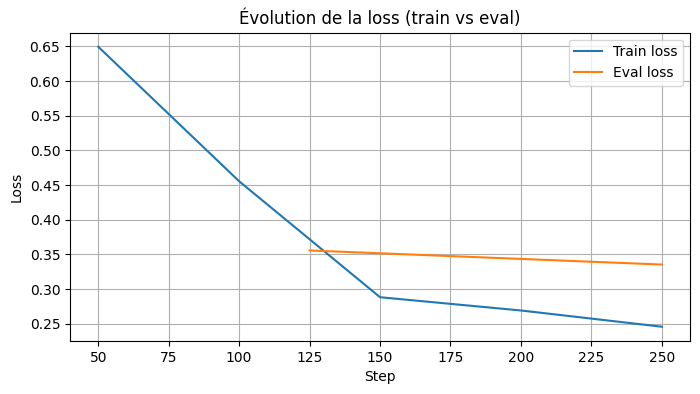

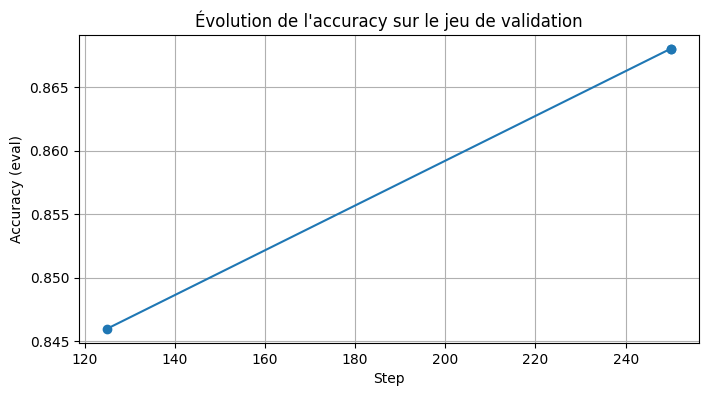

In [47]:
# ============================================================
# 7.1 — Courbes d'apprentissage : loss & accuracy
# ============================================================

import matplotlib.pyplot as plt

# trainer.state.log_history contient l'historique des logs
logs = trainer.state.log_history

train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []

for entry in logs:
    # Logs d'entraînement (loss)
    if "loss" in entry and "epoch" in entry and "step" in entry:
        train_steps.append(entry["step"])
        train_loss.append(entry["loss"])
    # Logs d'évaluation
    if "eval_loss" in entry:
        eval_steps.append(entry["step"])
        eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        eval_accuracy.append(entry["eval_accuracy"])

plt.figure(figsize=(8, 4))
plt.plot(train_steps, train_loss, label="Train loss")
plt.plot(eval_steps, eval_loss, label="Eval loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Évolution de la loss (train vs eval)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(eval_steps, eval_accuracy, marker="o")
plt.xlabel("Step")
plt.ylabel("Accuracy (eval)")
plt.title("Évolution de l'accuracy sur le jeu de validation")
plt.grid(True)
plt.show()


## 7.2 — Lecture des courbes d'apprentissage

En regardant les graphiques :

- La **loss d'entraînement** doit en général **décroître** au fil des steps.
- La **loss de validation** :
  - décroît aussi si le modèle apprend,
  - peut remonter si on commence à **sur-apprendre** (overfitting).

L'**accuracy de validation** permet de voir :

- si le modèle **progresse** au fil des epochs,
- si elle se stabilise,
- ou si elle se dégrade (signe potentiel d'overfitting ou de problèmes de généralisation).

 On peut se donner comme tâches :
- de comparer ces courbes avec celles d’un **modèle classique** (TF-IDF + régression logistique),
- d’ajuster le **nombre d’epochs** (1, 2, 3...) et d’observer l’impact sur les courbes.




---


#**✅De la QA au chatbot de discussion✅**


---




# 10. Transformer le RAG en chatbot de discussion

Jusqu'ici, notre RAG répond à des **questions indépendantes** :

- une question → retrieval → génération → réponse.

Pour obtenir un **chatbot de discussion**, il faut simplement ajouter :

1. Une **mémoire de conversation** (historique des tours précédents) :
   - garder les dernières questions/réponses,
   - les injecter dans le prompt pour conserver le fil.

2. Une **persona** / rôle :
   - par exemple : "assistant pédagogique", "tuteur de NLP", etc.
   - cela se fait principalement dans le **prompt** (aucun code magique supplémentaire).

3. Une **interface d’appel simple** :
   - une méthode `ask(...)` qui :
     - reçoit le message utilisateur,
     - met à jour l’historique,
     - appelle le RAG,
     - renvoie la réponse.

---

## 10.1 — Architecture conceptuelle du chatbot RAG

Schéma simplifié d’un tour de dialogue :

1. **Entrée utilisateur** : `message_t`
2. **Construction du contexte** :
   - on prend les `k` derniers (question, réponse),
   - on ajoute le `message_t`.
3. **Retrieval** (sur chunks) :
   - on encode `message_t`,
   - on cherche les chunks les plus proches dans l’index FAISS.
4. **Prompt RAG conversationnel** :
   - rôle + consignes,
   - historique,
   - documents pertinents,
   - question actuelle.
5. **Modèle génératif** (Flan-T5) :
   - produit une réponse `réponse_t`.
6. **Mise à jour de l’historique** :
   - on ajoute `(message_t, réponse_t)`.

 L’idée clé : *"Un chatbot RAG n’est rien d’autre qu’un RAG + un peu de mémoire."*


##**Chatbot RAG “propre” basé chunks**

On part de search_chunks_faiss et build_chat_prompt qu’on avait déjà.
On va juste simplifier et “officialiser” une classe ConversationalRAG.

In [1]:
# ============================================================
# 10.2 — Chatbot RAG de discussion (sans sentiment)
# Base : RAG sur chunks + historique
# ============================================================

class ConversationalRAG:
    def __init__(self, top_k=3, max_new_tokens=128, max_history=3):
        """
        top_k        : nombre de chunks à récupérer à chaque tour
        max_new_tokens : longueur max de la réponse générée
        max_history  : nombre de tours précédents à inclure dans le prompt
        """
        self.history = []  # liste de tuples (question, answer)
        self.top_k = top_k
        self.max_new_tokens = max_new_tokens
        self.max_history = max_history

    def build_prompt(self, user_message, retrieved_passages):
        """
        Construit un prompt conversationnel pour Flan-T5,
        en utilisant l'historique et les chunks pertinents.
        """
        # Historique compact
        hist_text = ""
        for (q, a) in self.history[-self.max_history:]:
            hist_text += f"Utilisateur : {q}\nAssistant : {a}\n"

        # Documents
        docs_text = ""
        for i, doc in enumerate(retrieved_passages):
            docs_text += f"[DOC {i+1}] {doc['content']}\n"

        prompt = (
            "Tu es un assistant pédagogique spécialisé dans ce texte.\n"
            "Tu dois répondre UNIQUEMENT à partir des documents fournis.\n"
            "Si une information n'est pas dans les documents, dis honnêtement que tu ne sais pas.\n\n"
            "Historique récent de la conversation :\n"
            f"{hist_text}\n"
            "Documents pertinents :\n"
            f"{docs_text}\n"
            f"Message actuel de l'utilisateur : {user_message}\n\n"
            "Réponse en français, claire et structurée :"
        )
        return prompt

    def ask(self, user_message):
        """
        Un tour de conversation :
        - retrieval sur les chunks,
        - génération de la réponse,
        - mise à jour de l'historique,
        - affichage pédagogique.
        """
        # 1) Retrieval
        retrieved = search_chunks_faiss(user_message, top_k=self.top_k)

        # 2) Prompt
        prompt = self.build_prompt(user_message, retrieved)

        # 3) Génération
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
        output = gen_model.generate(
            **inputs,
            max_new_tokens=self.max_new_tokens,
            do_sample=False
        )
        answer = tokenizer.decode(output[0], skip_special_tokens=True)

        # 4) Historique
        self.history.append((user_message, answer))

        # 5) Affichage
        print("❓ Vous :", user_message)
        print("\n🤖 Assistant :")
        print(answer)

        print("\n📚 Chunks utilisés :")
        for i, p in enumerate(retrieved):
            print(f"\n[CHUNK {p['chunk_index']}] (score={p['score']:.3f})")
            print(p["content"])
        print("\n" + "-"*80)

    def reset_history(self):
        self.history = []
        print("🧹 Historique du chatbot RAG réinitialisé.")


##**Exemple de session de discussion**

In [27]:
# ============================================================
# 10.3 — Exemple de session de discussion
# ============================================================

chat_discuss = ConversationalRAG(top_k=3, max_new_tokens=128, max_history=3)

# Tour 1 : question de base
chat_discuss.ask("Peux-tu m'expliquer ce qu'est le NLP selon ce texte ?")

# Tour 2 : question de suivi
chat_discuss.ask("Et en quoi les Transformers ont changé la manière de faire du NLP ?")

# Tour 3 : question sur le RAG
chat_discuss.ask("Explique comment le RAG s'insère dans ce pipeline moderne.")

# Pour repartir à zéro :
# chat_discuss.reset_history()


❓ Vous : Peux-tu m'expliquer ce qu'est le NLP selon ce texte ?

🤖 Assistant :
                                                               

📚 Chunks utilisés :

[CHUNK 0] (score=0.502)
Le traitement automatique du langage naturel, ou NLP, est une branche de l'intelligence artificielle
qui s'intéresse à l'interaction entre les ordinateurs et le langage humain. Historiquement, le NLP
s'appuyait sur des méthodes symboliques, des règles linguistiques et des modèles statistiques simples
tels que les modèles n-grammes. Avec l'essor de l'apprentissage profond, les réseaux de neurones récurrents puis les Transformers
ont radicalement changé la manière dont on traite le texte.

[CHUNK 4] (score=0.494)
Le découpage en chunks et l'indexation vectorielle permettent
de faire des recherches efficaces sur ces grands corpus.

[CHUNK 1] (score=0.433)
Les modèles pré-entraînés sur de grands
corpus, comme BERT ou GPT, permettent de capturer des représentations riches du langage. Les embeddings de mots

## 10.4 — Pourquoi ce chatbot est déjà un "vrai" assistant de discussion ?

Ce chatbot :

1. **Réutilise le RAG sur chunks** :
   - chaque message déclenche un retrieval sur l'index FAISS,
   - les réponses sont ancrées dans le texte fourni.

2. **Gère un historique simple** (fenêtre glissante) :
   - permet d'enchaîner des questions,
   - le modèle voit un contexte de conversation.

3. **Est contrôlé par le prompt** :
   - persona (assistant pédagogique),
   - consigne de ne pas inventer,
   - style (clair, structuré).

---

### 🧠 Démystification

Il n'y a pas de magie cachée :

- Pas besoin d'un "moteur de dialogue" supplémentaire,
- Pas besoin d'un algorithme compliqué de gestion de contexte.

Un **chatbot RAG moderne**, dans beaucoup d'architectures réelles, c’est simplement :

> 🔹 des embeddings +  
> 🔹 un index vectoriel +  
> 🔹 un peu de logique Python (historique) +  
> 🔹 un modèle génératif +  
> 🔹 un prompt bien conçu.

Tout ce que nous avons fait dans ce notebook.

---

Pour aller plus loin, on peut envisager un **petit fine-tuning de style** du modèle génératif, ce qui est l’objet de la section suivante.


# 11. Mini fine-tuning de style (idée avancée)

Jusqu'ici, nous avons contrôlé le comportement du modèle génératif principalement par :

- le **prompt** (persona, consignes),
- le contexte (historique + documents).

On peut aller plus loin avec un **fine-tuning léger** :

- prendre un petit modèle (ex. `google/flan-t5-small`),
- préparer quelques dizaines / centaines d'exemples de type :

  - *Entrée* : "Question de l'étudiant + extraits du cours"
  - *Sortie attendue* : "Réponse dans le style que l'on souhaite"  
    (par exemple : très pédagogique, avec plan, exemples, etc.)

- faire un fine-tuning **court** sur ces paires (instruction-tuning "local").

L'objectif n'est pas d'améliorer radicalement la performance,
mais d'**adapter le ton et le style** de l'assistant :

- plus structuré,
- plus académique,
- plus adapté à ton contexte de cours.

Pour des raisons de temps et de ressources, on se contente ici d'un **squelette** de code.


In [28]:
# ============================================================
# 11.2 — Squelette de mini fine-tuning de style (OPTIONNEL)
# ============================================================
# ⚠️ À n'exécuter que si tu veux expérimenter en profondeur.
# Idée : créer un petit dataset "input → output" avec le style souhaité.

from datasets import Dataset
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

# Exemples jouets : à remplacer par tes propres paires (cours, explications...)
examples = [
    {
        "input": "Explique ce qu'est le NLP à un étudiant débutant.",
        "target": "Le traitement automatique du langage naturel (NLP) est une branche de l'IA qui vise à permettre aux machines de comprendre et de générer du langage humain. Par exemple, la classification de sentiments, la traduction automatique, ou les chatbots."
    },
    {
        "input": "Explique en quelques phrases le principe du RAG.",
        "target": "Le RAG, pour Retrieval-Augmented Generation, combine deux étapes : d'abord, on récupère des passages pertinents dans une base de documents ; ensuite, un modèle de génération produit une réponse en s'appuyant sur ces passages. Cela permet d'ancrer les réponses dans une connaissance externe mise à jour."
    },
    {
        "input": "Explique simplement ce qu'est un embedding de phrase.",
        "target": "Un embedding de phrase est une représentation numérique compacte d'une phrase sous forme de vecteur. Deux phrases qui veulent dire à peu près la même chose auront des vecteurs proches dans cet espace."
    }
]

style_dataset = Dataset.from_list(examples)

def preprocess_style_batch(batch):
    model_input = [
        "Instruction : " + inp + "\nRéponse pédagogique :"
        for inp in batch["input"]
    ]
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["target"], truncation=True, padding="max_length", max_length=128)
    encodings = tokenizer(model_input, truncation=True, padding="max_length", max_length=128)
    encodings["labels"] = labels["input_ids"]
    return encodings

tokenizer = tokenizer  # alias pour clarté
style_dataset_tokenized = style_dataset.map(preprocess_style_batch, batched=True)

data_collator_seq2seq = DataCollatorForSeq2Seq(tokenizer, model=gen_model)

ft_args = Seq2SeqTrainingArguments(
    output_dir="./flan-t5-style-ft",
    per_device_train_batch_size=2,
    learning_rate=5e-5,
    num_train_epochs=3,
    logging_steps=1,
    save_strategy="no",
    predict_with_generate=True
)

style_trainer = Seq2SeqTrainer(
    model=gen_model,
    args=ft_args,
    train_dataset=style_dataset_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator_seq2seq
)

#  À lancer seulement si tu as le temps / GPU dispo
# style_trainer.train()


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/tmp/ipython-input-2339742412.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  style_trainer = Seq2SeqTrainer(


In [29]:
#  À lancer seulement si tu as le temps / GPU dispo
style_trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: t-masrour (t-masrour-ensam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,23.259200
2,15.196100
3,17.484500
4,22.305400
5,17.779600
6,18.262800


TrainOutput(global_step=6, training_loss=19.047921975453693, metrics={'train_runtime': 41.8374, 'train_samples_per_second': 0.215, 'train_steps_per_second': 0.143, 'total_flos': 418253635584.0, 'train_loss': 19.047921975453693, 'epoch': 3.0})

## 11.3 — Conclusion sur le fine-tuning de style

Ce squelette illustre l'idée suivante :

- On peut **prendre le même modèle génératif** (Flan-T5),
- le **réentraîner légèrement** sur quelques exemples bien choisis,
- pour "caler" son style sur :
  - celui d'un enseignant,
  - d'un support de cours,
  - d'une école ou d'une entreprise.



---

Avec ce bloc, ce notebook offre une vue complète :

- RAG → QA,
- RAG → Chatbot de discussion,
- et une porte d'entrée vers **l'adaptation de style** par fine-tuning.




---



---






---



---



---



---

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
---



---



---



# 11. Mini fine-tuning de style (BONUS, option avancée)

Dans tout le notebook, nous avons contrôlé le comportement du modèle génératif
principalement par :

- le **prompt** (persona, consignes),
- le **contexte** (historique + documents).

Cette section montre, de façon **purement illustrative**, comment faire un
**mini fine-tuning de style** sur le modèle génératif (Flan-T5).

🎯 **Objectif pédagogique** :

- Comprendre la **pipeline générale** d’un fine-tuning Seq2Seq :
  - préparation d’un petit dataset (input → output),
  - tokenisation,
  - entraînement avec `Seq2SeqTrainer`.
- Ne PAS chercher ici :
  - des performances élevées,
  - une loss "belle" ou parfaitement stable.

⚠️ **Consignes ** :

- Cette section est **optionnelle** et peut être ignorée sans problème.
- Ne lancez le fine-tuning que si :
  - vous êtes sur GPU,
  - vous avez le temps (quelques minutes).
- Le dataset est volontairement **très petit (≈ 10–15 exemples)** :
  - ce n’est pas pour battre des records,
  - mais pour illustrer la mécanique.


In [30]:
# ============================================================
# 11.2 — Mini dataset de style : questions → réponses pédagogiques
# ============================================================

from datasets import Dataset

style_examples = [
    {
        "input": "Explique ce qu'est le NLP à un étudiant débutant.",
        "target": ("Le traitement automatique du langage naturel (NLP) est une branche de "
                   "l'intelligence artificielle qui vise à permettre aux machines de comprendre "
                   "et de générer du langage humain. Par exemple, on l'utilise pour les "
                   "chatbots, la classification de sentiments ou la traduction automatique.")
    },
    {
        "input": "Explique simplement ce qu'est un embedding de phrase.",
        "target": ("Un embedding de phrase est une façon de représenter une phrase sous forme "
                   "d'un vecteur de nombres. Deux phrases qui ont un sens proche auront des "
                   "vecteurs proches, ce qui permet de mesurer leur similarité.")
    },
    {
        "input": "Explique en quelques phrases le principe du RAG.",
        "target": ("Le RAG, pour Retrieval-Augmented Generation, combine deux étapes : d'abord, "
                   "on récupère des passages pertinents dans une base de documents ; ensuite, "
                   "un modèle de génération produit une réponse en s'appuyant sur ces passages. "
                   "Cela permet d'ancrer les réponses dans une connaissance externe mise à jour.")
    },
    {
        "input": "Explique le lien entre embeddings et moteur de recherche sémantique.",
        "target": ("Un moteur de recherche sémantique utilise des embeddings pour représenter "
                   "les phrases et les documents. Quand l'utilisateur pose une question, on la "
                   "convertit en vecteur et on cherche les documents dont les vecteurs sont les "
                   "plus proches. On récupère ainsi les textes les plus proches en sens.")
    },
    {
        "input": "Explique la différence entre TF-IDF et embeddings modernes.",
        "target": ("TF-IDF représente chaque document par des compteurs de mots pondérés, sans "
                   "vraiment comprendre le sens. Les embeddings modernes, eux, produisent des "
                   "vecteurs denses qui capturent la signification globale du texte et les "
                   "relations entre les mots.")
    },
    {
        "input": "Explique ce qu'apporte un Transformer par rapport à un RNN.",
        "target": ("Les Transformers utilisent un mécanisme d'attention qui permet de regarder "
                   "tous les mots de la phrase en parallèle et de modéliser plus facilement les "
                   "dépendances longues. Ils sont plus simples à entraîner que les RNN profonds "
                   "et sont devenus la base de la plupart des modèles de NLP modernes.")
    },
    {
        "input": "Explique pourquoi on découpe un long document en chunks pour le RAG.",
        "target": ("On découpe un long document en chunks pour que chaque morceau ait une taille "
                   "gérable par le modèle et pour pouvoir indexer finement le contenu. Au moment "
                   "d'une question, on ne charge que quelques chunks pertinents au lieu de tout "
                   "le document, ce qui est plus efficace et plus précis.")
    },
    {
        "input": "Explique la notion de base de connaissances externe dans le RAG.",
        "target": ("Dans un système RAG, la base de connaissances externe contient les documents "
                   "sur lesquels on veut s'appuyer : cours, articles, documentation technique, "
                   "etc. Le modèle n'a pas besoin de tout mémoriser dans ses poids, il consulte "
                   "cette base à la demande via le retrieval.")
    },
    {
        "input": "Explique comment un chatbot RAG utilise l'historique de la conversation.",
        "target": ("Un chatbot RAG garde en mémoire les derniers échanges sous forme de texte. "
                   "Lors d'une nouvelle question, il inclut cet historique dans le prompt, en "
                   "plus des documents récupérés. Cela lui permet de répondre de manière cohérente "
                   "avec le fil de la discussion.")
    },
    {
        "input": "Explique en une phrase l'idée générale de ce notebook.",
        "target": ("Ce notebook montre comment passer des méthodes de NLP classiques à un "
                   "pipeline moderne combinant embeddings, retrieval, RAG et Transformers pour "
                   "la classification et la génération.")
    },
    {
        "input": "Donne une courte définition pédagogique de Transformer.",
        "target": ("Un Transformer est un type de réseau de neurones qui utilise l'attention "
                   "pour traiter des séquences en parallèle et modéliser les relations entre "
                   "les éléments d'une phrase ou d'un texte.")
    },
    {
        "input": "Donne une courte définition pédagogique de chatbot RAG.",
        "target": ("Un chatbot RAG est un assistant conversationnel qui va d'abord chercher des "
                   "documents pertinents, puis génère une réponse en se basant sur ces documents, "
                   "plutôt que sur sa seule mémoire interne.")
    }
]

style_dataset = Dataset.from_list(style_examples)
style_dataset


Dataset({
    features: ['input', 'target'],
    num_rows: 12
})

In [31]:
# ============================================================
# 11.3 — Prétraitement du mini dataset pour Flan-T5
# ============================================================

from transformers import DataCollatorForSeq2Seq

# On utilise le tokenizer de Flan-T5 (déjà défini plus haut : `tokenizer`)
max_input_length = 128
max_target_length = 128

def preprocess_style_batch(batch):
    # On construit un texte d'entrée légèrement "instructionnalisé"
    inputs = [
        "Instruction : " + inp + "\nRéponse attendue :"
        for inp in batch["input"]
    ]

    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding="max_length"
    )

    # Labels (texte cible)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["target"],
            max_length=max_target_length,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

style_dataset_tokenized = style_dataset.map(preprocess_style_batch, batched=True)

data_collator_seq2seq = DataCollatorForSeq2Seq(tokenizer, model=gen_model)

style_dataset_tokenized


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Dataset({
    features: ['input', 'target', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 12
})

In [33]:
# ============================================================
# 11.4 — Configuration du mini fine-tuning (sans W&B)
# ============================================================

import os
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# Désactiver totalement Weights & Biases pour ce notebook
os.environ["WANDB_DISABLED"] = "true"

ft_args = Seq2SeqTrainingArguments(
    output_dir="./flan-t5-style-ft",
    per_device_train_batch_size=2,
    learning_rate=5e-5,
    num_train_epochs=3,
    logging_steps=1,
    save_strategy="no",       # on ne sauvegarde pas à chaque epoch
    predict_with_generate=True,
    report_to="none"          # ✅ pas de wandb, pas de tensorboard
)

style_trainer = Seq2SeqTrainer(
    model=gen_model,
    args=ft_args,
    train_dataset=style_dataset_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator_seq2seq,
)

print("✅ Trainer style configuré (mini dataset, pas de W&B).")


✅ Trainer style configuré (mini dataset, pas de W&B).


/tmp/ipython-input-156332550.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  style_trainer = Seq2SeqTrainer(


In [34]:
# ============================================================
# 11.5 — Lancement OPTIONNEL du mini fine-tuning
# ============================================================



style_trainer.train()


Step,Training Loss
1,17.196800
2,18.403700
3,15.135200
4,20.463600
5,14.735500
6,17.675400
7,14.386800
8,13.286100
9,17.263700
10,15.367200


TrainOutput(global_step=18, training_loss=15.720670541127523, metrics={'train_runtime': 87.2847, 'train_samples_per_second': 0.412, 'train_steps_per_second': 0.206, 'total_flos': 1673014542336.0, 'train_loss': 15.720670541127523, 'epoch': 3.0})

In [35]:
# ============================================================
# 11.6 — Test qualitatif après (éventuel) fine-tuning
# ============================================================

def generate_pedago_answer(instruction, max_new_tokens=128):
    """
    Petit helper pour interroger Flan-T5 dans le format de la tâche de style.
    """
    prompt = f"Instruction : {instruction}\nRéponse attendue :"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    output = gen_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False
    )
    answer = tokenizer.decode(output[0], skip_special_tokens=True)
    print("Instruction :", instruction)
    print("\nRéponse du modèle :")
    print(answer)
    print("\n" + "-"*60)

# Exemple de tests (avant et/ou après fine-tuning)
generate_pedago_answer("Explique ce qu'est le NLP à un étudiant débutant.")
generate_pedago_answer("Explique en quelques phrases le principe du RAG.")
generate_pedago_answer("Explique simplement ce qu'est un embedding de phrase.")


Instruction : Explique ce qu'est le NLP à un étudiant débutant.

Réponse du modèle :
Attendee :

------------------------------------------------------------
Instruction : Explique en quelques phrases le principe du RAG.

Réponse du modèle :
RAG :                                                              

------------------------------------------------------------
Instruction : Explique simplement ce qu'est un embedding de phrase.

Réponse du modèle :
                                                               

------------------------------------------------------------


## Code pour le projet big_data

In [3]:
# !pip install pyspark tensorflow transformers torch

In [5]:
# !pip install datasets huggingface_hub

In [ ]:
# Databricks notebook (Python cell)



In [11]:
from datasets import load_dataset

data = load_dataset("yaful/MAGE")   # remplace par le repo HF
# Exemple: ds['train'].to_csv('/dbfs/mnt/raw/mydataset_train.csv')

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import gc

In [13]:
import torch
print("Is CUDA available? ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())
print("Current GPU: ", torch.cuda.current_device())
print("GPU Name: ", torch.cuda.get_device_name(0))

Is CUDA available?  True
Number of GPUs:  1
Current GPU:  0
GPU Name:  NVIDIA GeForce RTX 4060 Laptop GPU


In [15]:
# Session Spark avec configuration mémoire optimisée pour Windows
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.storagelevel import StorageLevel
import gc

# Configuration optimisée pour la mémoire (sans GPU)
conf = SparkConf() \
    .setAppName("NLP_Memory_Optimized") \
    .set("spark.sql.adaptive.enabled", "true") \
    .set("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .set("spark.sql.adaptive.skew.enabled", "true") \
    .set("spark.sql.autoBroadcastJoinThreshold", "10m") \
    .set("spark.sql.shuffle.partitions", "100") \
    .set("spark.memory.fraction", "0.8") \
    .set("spark.memory.storageFraction", "0.3") \
    .set("spark.executor.memoryOverhead", "1g") \
    .set("spark.driver.memory", "4g") \
    .set("spark.executor.memory", "4g") \
    .set("spark.driver.maxResultSize", "2g")

spark = SparkSession.builder.config(conf=conf).getOrCreate()

def optimized_convert_to_spark_dataframes(dataset_dict):
    """Conversion optimisée avec partitionnement"""
    spark_dataframes = {}
    for split_name, dataset in dataset_dict.items():
        pandas_df = dataset.to_pandas()
        # Création avec partitionnement adapté
        spark_df = spark.createDataFrame(pandas_df).repartition(8)  # Augmente les partitions pour mieux distribuer
        spark_dataframes[split_name] = spark_df
        print(f"Converted {split_name}: {spark_df.count()} rows")
    return spark_dataframes

# Conversion optimisée
print("=== Conversion des données ===")
spark_dfs = optimized_convert_to_spark_dataframes(data)

# ============= PREPROCESSING OPTIMISÉ =============
print("\n=== Préprocessing Optimisé ===")

from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml import Pipeline

def process_in_batches(df, preprocessing_model, batch_size=5000):
    """Traitement par batch pour éviter l'explosion mémoire"""
    from pyspark.sql import functions as F
    from pyspark.sql.window import Window
    
    total_count = df.count()
    print(f"Traitement de {total_count} lignes par batch de {batch_size}")
    
    # Ajout d'un index pour le batch processing
    df_with_index = df.withColumn("row_index", F.monotonically_increasing_id())
    
    processed_parts = []
    max_index = df_with_index.agg(F.max("row_index")).collect()[0][0]
    
    for i in range(0, total_count, batch_size):
        print(f"Traitement du batch {i//batch_size + 1}/{(total_count + batch_size - 1)//batch_size}")
        
        # Filtrage par plage d'index
        batch_df = df_with_index.filter(
            (F.col("row_index") >= i) & (F.col("row_index") < i + batch_size)
        ).drop("row_index")
        
        processed_batch = preprocessing_model.transform(batch_df)
        processed_parts.append(processed_batch)
        
        # Libération mémoire après chaque batch
        batch_df.unpersist()
        del batch_df
        gc.collect()
    
    # Union de tous les batches
    from functools import reduce
    from pyspark.sql import DataFrame
    
    if processed_parts:
        result = processed_parts[0]
        for i in range(1, len(processed_parts)):
            result = result.union(processed_parts[i])
        return result
    else:
        return spark.createDataFrame([], df.schema)

# Pipeline de préprocessing avec vocabulaire réduit
tokenizer = Tokenizer(inputCol="text", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# VOCABULAIRE RÉDUIT et paramètres optimisés
vectorizer = CountVectorizer(
    inputCol="filtered_words", 
    outputCol="raw_features", 
    vocabSize=1000,  # Réduit significativement
    minDF=5.0,       # Ignore les mots trop rares
    minTF=1.0
)

preprocessing_pipeline = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer])

print("Fitting preprocessing pipeline...")
# Fit sur un échantillon pour économiser la mémoire
sample_ratio = min(0.3, 10000/spark_dfs['train'].count())  # Maximum 30% ou 10k lignes
sample_df = spark_dfs['train'].sample(False, sample_ratio, seed=42)
preprocessing_model = preprocessing_pipeline.fit(sample_df)
sample_df.unpersist()
del sample_df
gc.collect()

print("Transformation des données...")
# Transformation avec gestion mémoire
train_processed = process_in_batches(spark_dfs['train'], preprocessing_model, batch_size=2000)
val_processed = process_in_batches(spark_dfs['validation'], preprocessing_model, batch_size=2000)
test_processed = process_in_batches(spark_dfs['test'], preprocessing_model, batch_size=2000)

# Cache avec stratégie MEMORY_AND_DISK
train_processed.persist(StorageLevel.MEMORY_AND_DISK)
val_processed.persist(StorageLevel.MEMORY_AND_DISK)
test_processed.persist(StorageLevel.MEMORY_AND_DISK)

print("Échantillon des données après preprocessing:")
train_processed.select("text", "label", "raw_features").show(2, truncate=30)

# Libération immédiate des données brutes
for split in ['train', 'validation', 'test']:
    spark_dfs[split].unpersist()
    del spark_dfs[split]
gc.collect()

# ============= MODÈLE MLP OPTIMISÉ =============
print("\n=== Configuration du modèle ===")

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Détermination des dimensions
vocab_size = len(preprocessing_model.stages[2].vocabulary)
num_classes = train_processed.select("label").distinct().count()

print(f"Taille du vocabulaire: {vocab_size}")
print(f"Nombre de classes: {num_classes}")

# Architecture réduite pour la mémoire
layers = [vocab_size, 256, 128, num_classes]  # Architecture simplifiée

model = MultilayerPerceptronClassifier(
    featuresCol="raw_features",
    labelCol="label",
    layers=layers,
    blockSize=128,
    maxIter=15,              # Réduit pour tests rapides
    tol=1e-3,                # Tolérance pour early stopping
    seed=42
)

# ============= ENTRAÎNEMENT =============
print("\n=== Début de l'entraînement ===")

spark.sparkContext.setLogLevel("WARN")  # Réduit les logs pendant l'entraînement

trained_model = model.fit(train_processed)
print("Entraînement terminé!")

# ============= ÉVALUATION OPTIMISÉE =============
print("\n=== Évaluation optimisée ===")

def evaluate_in_batches(model, df, batch_size=2000):
    """Évaluation par batch pour économiser la mémoire"""
    from pyspark.sql import functions as F
    
    total_count = df.count()
    print(f"Évaluation de {total_count} lignes par batch de {batch_size}")
    
    # Ajout d'un index pour le batch processing
    df_with_index = df.withColumn("row_index", F.monotonically_increasing_id())
    
    predictions_list = []
    
    for i in range(0, total_count, batch_size):
        print(f"Évaluation du batch {i//batch_size + 1}/{(total_count + batch_size - 1)//batch_size}")
        
        # Filtrage par plage d'index
        batch_df = df_with_index.filter(
            (F.col("row_index") >= i) & (F.col("row_index") < i + batch_size)
        ).drop("row_index")
        
        batch_predictions = model.transform(batch_df)
        predictions_list.append(batch_predictions)
        
        batch_df.unpersist()
        del batch_df
        gc.collect()
    
    # Union de tous les batches
    from functools import reduce
    from pyspark.sql import DataFrame
    
    if predictions_list:
        result = predictions_list[0]
        for i in range(1, len(predictions_list)):
            result = result.union(predictions_list[i])
        return result
    else:
        return spark.createDataFrame([], df.schema)

# Évaluation par batch
print("Calcul des prédictions...")
val_predictions = evaluate_in_batches(trained_model, val_processed)
test_predictions = evaluate_in_batches(trained_model, test_processed)

# Cache des prédictions
val_predictions.persist(StorageLevel.MEMORY_AND_DISK)
test_predictions.persist(StorageLevel.MEMORY_AND_DISK)

# Évaluateur
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy"
)

# Calcul des métriques
val_accuracy = evaluator.evaluate(val_predictions)
test_accuracy = evaluator.evaluate(test_predictions)

print(f"\n{'='*50}")
print(f"Accuracy - Validation: {val_accuracy:.4f}")
print(f"Accuracy - Test: {test_accuracy:.4f}")
print(f"{'='*50}")

# Métriques supplémentaires uniquement si nécessaire
if val_accuracy > 0.5:  # Seulement si le modèle est raisonnable
    for metric_name in ["f1", "weightedPrecision", "weightedRecall"]:
        evaluator.setMetricName(metric_name)
        val_metric = evaluator.evaluate(val_predictions)
        test_metric = evaluator.evaluate(test_predictions)
        print(f"{metric_name:20s} - Val: {val_metric:.4f}, Test: {test_metric:.4f}")

# ============= NETTOYAGE MÉMOIRE COMPLET =============
print("\n=== Nettoyage complet de la mémoire ===")

# Libération séquentielle
datasets_to_clean = [
    train_processed, val_processed, test_processed,
    val_predictions, test_predictions
]

for dataset in datasets_to_clean:
    try:
        dataset.unpersist()
        del dataset
    except:
        pass

# Libération des modèles
del trained_model
del preprocessing_model
del model

# Nettoyage mémoire aggressive
gc.collect()
spark.catalog.clearCache()

print("✅ Terminé avec optimisation mémoire!")

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable